In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec
from scipy.optimize import leastsq



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_sx1.fits'],
      dtype='<U67')

In [3]:
# for x in x1ds:
#     print(x)
#     print(fits.getheader(x, 0)['OPT_ELEM'])
#     data = fits.getdata(x, 1)
#     print(data['A2Center'])
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     mask = w > 1160
#     w, f, e = w[mask], f[mask], e[mask]
#     plt.step(w, f, where='mid', c='C0')
#     plt.step(w, e, where='mid', c='C1')
#     plt.show()

    

In [4]:
# for x in x1ds[3:]:
#     print(x)
#     print(fits.getheader(x, 0)['OPT_ELEM'])
#     data = fits.getdata(x, 1)
#     print(data['A2Center'])
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     mask = w > 1160
#     w, f, e = w[mask], f[mask], e[mask]
#     plt.step(w, f, where='mid', c='C0')
#     plt.step(w, e, where='mid', c='C1')


# plt.yscale('log')
# plt.xscale('log')

# plt.show()





In [5]:
# flts = glob.glob('{}*flt.fits'.format(path))
# flts

In [6]:
# checkrow = 200
# for flt in flts:
#     hdr = fits.getheader(flt, 0)
#     grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
#     if grating == 'G140L':       
#         print(root)
#         data = fits.getdata(flt, 1)
#         data = np.transpose(data) #flip the image to make the next row more simple
#         data = data[350:800]
#         data = np.sum(data, axis=0)
#         data = convolve(data,  Box1DKernel(4))
#         plt.plot(np.arange(len(data)), data)
        
#         spec = fits.getdata('{}{}_x1d.fits'.format(path, root))[0]
#         [plt.axvline(line, c='C1') for line in (spec['A2CENTER'], spec['A2CENTER']+spec['BK1OFFST'], spec['A2CENTER']+spec['BK2OFFST'])]
#         plt.axvline(spec['A2CENTER'], c='C2')      
#         plt.ylabel('Counts (s$^{-1}$)')
#         plt.xlabel('Spatial Axis Detector Pixel')
#         plt.annotate('{}'.format(root), (0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
#         plt.xlim(450, 550)
#         plt.tight_layout()
        # plt.show()

Need to re-extract the G140L (+ maybe G140M) spectra. S/N is really low, might need to coadd flats before extracting.

In [60]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [65]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

76.44858


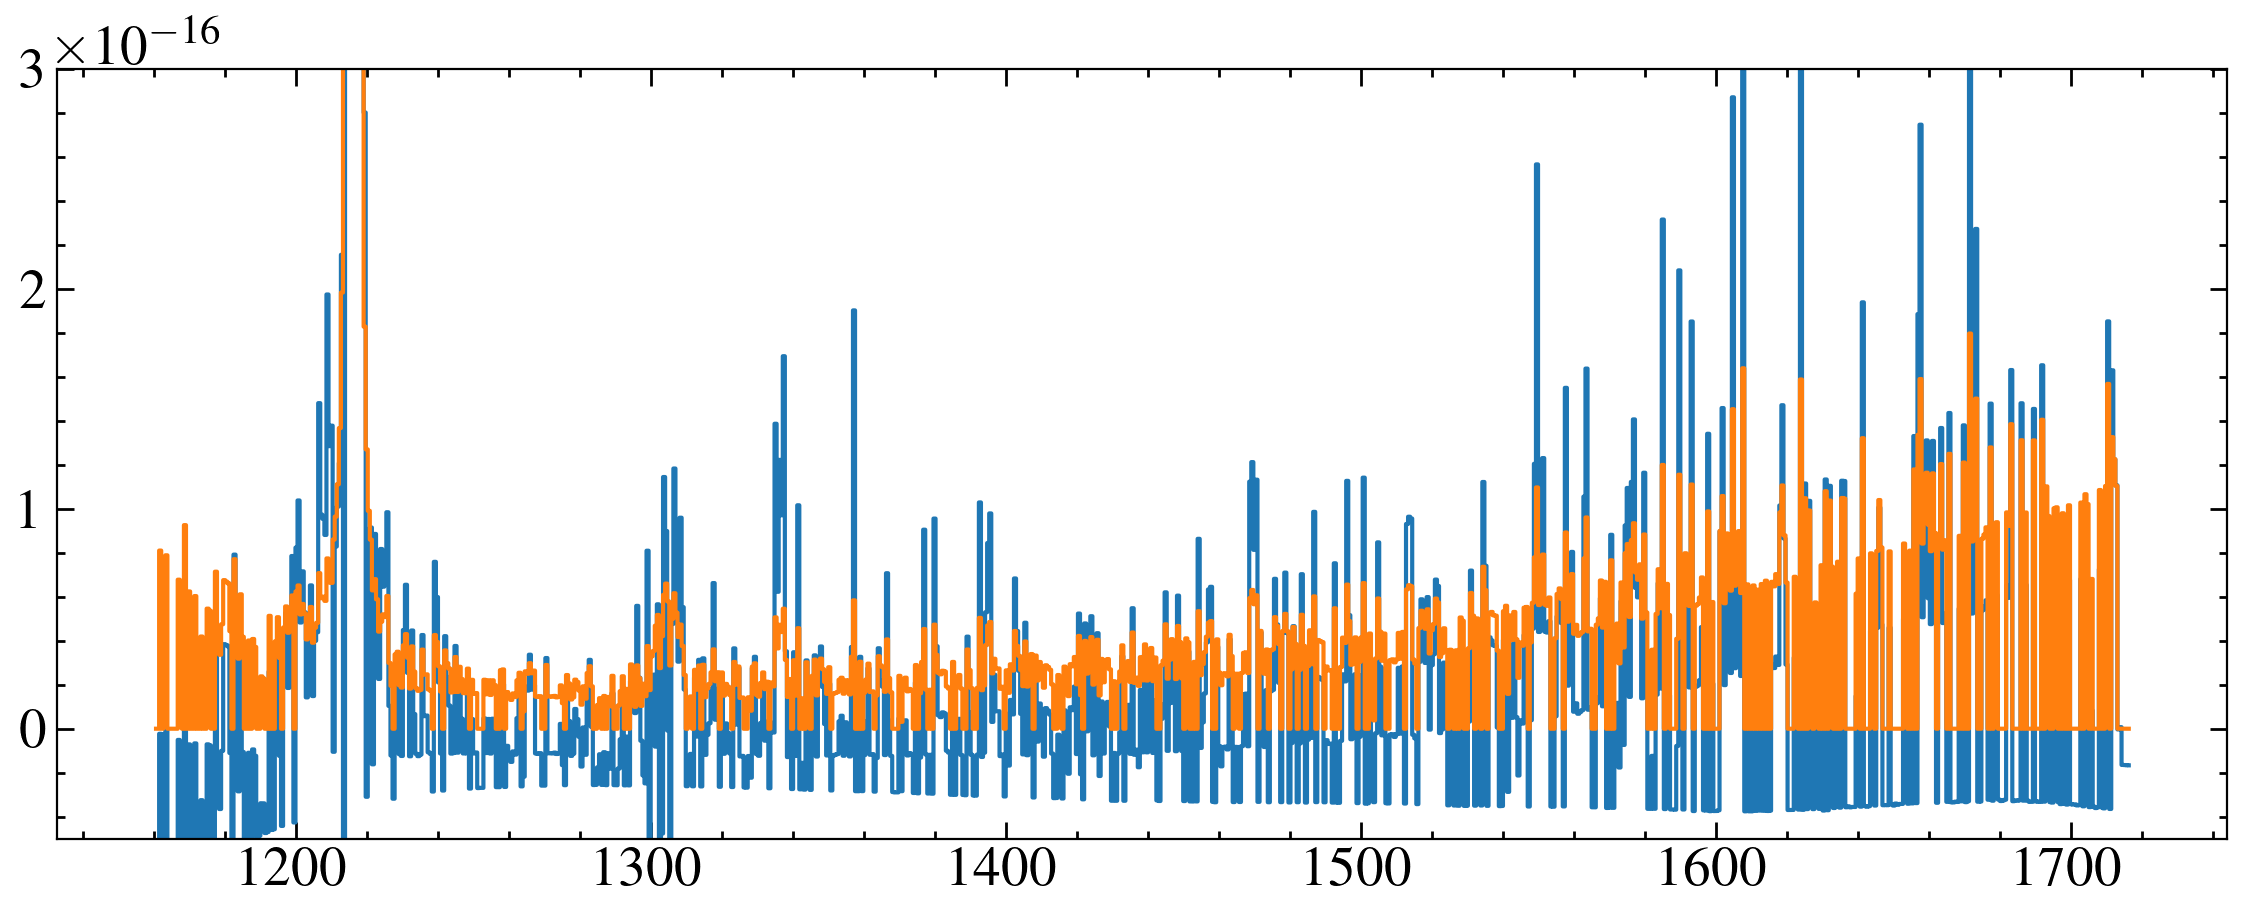

76.90985


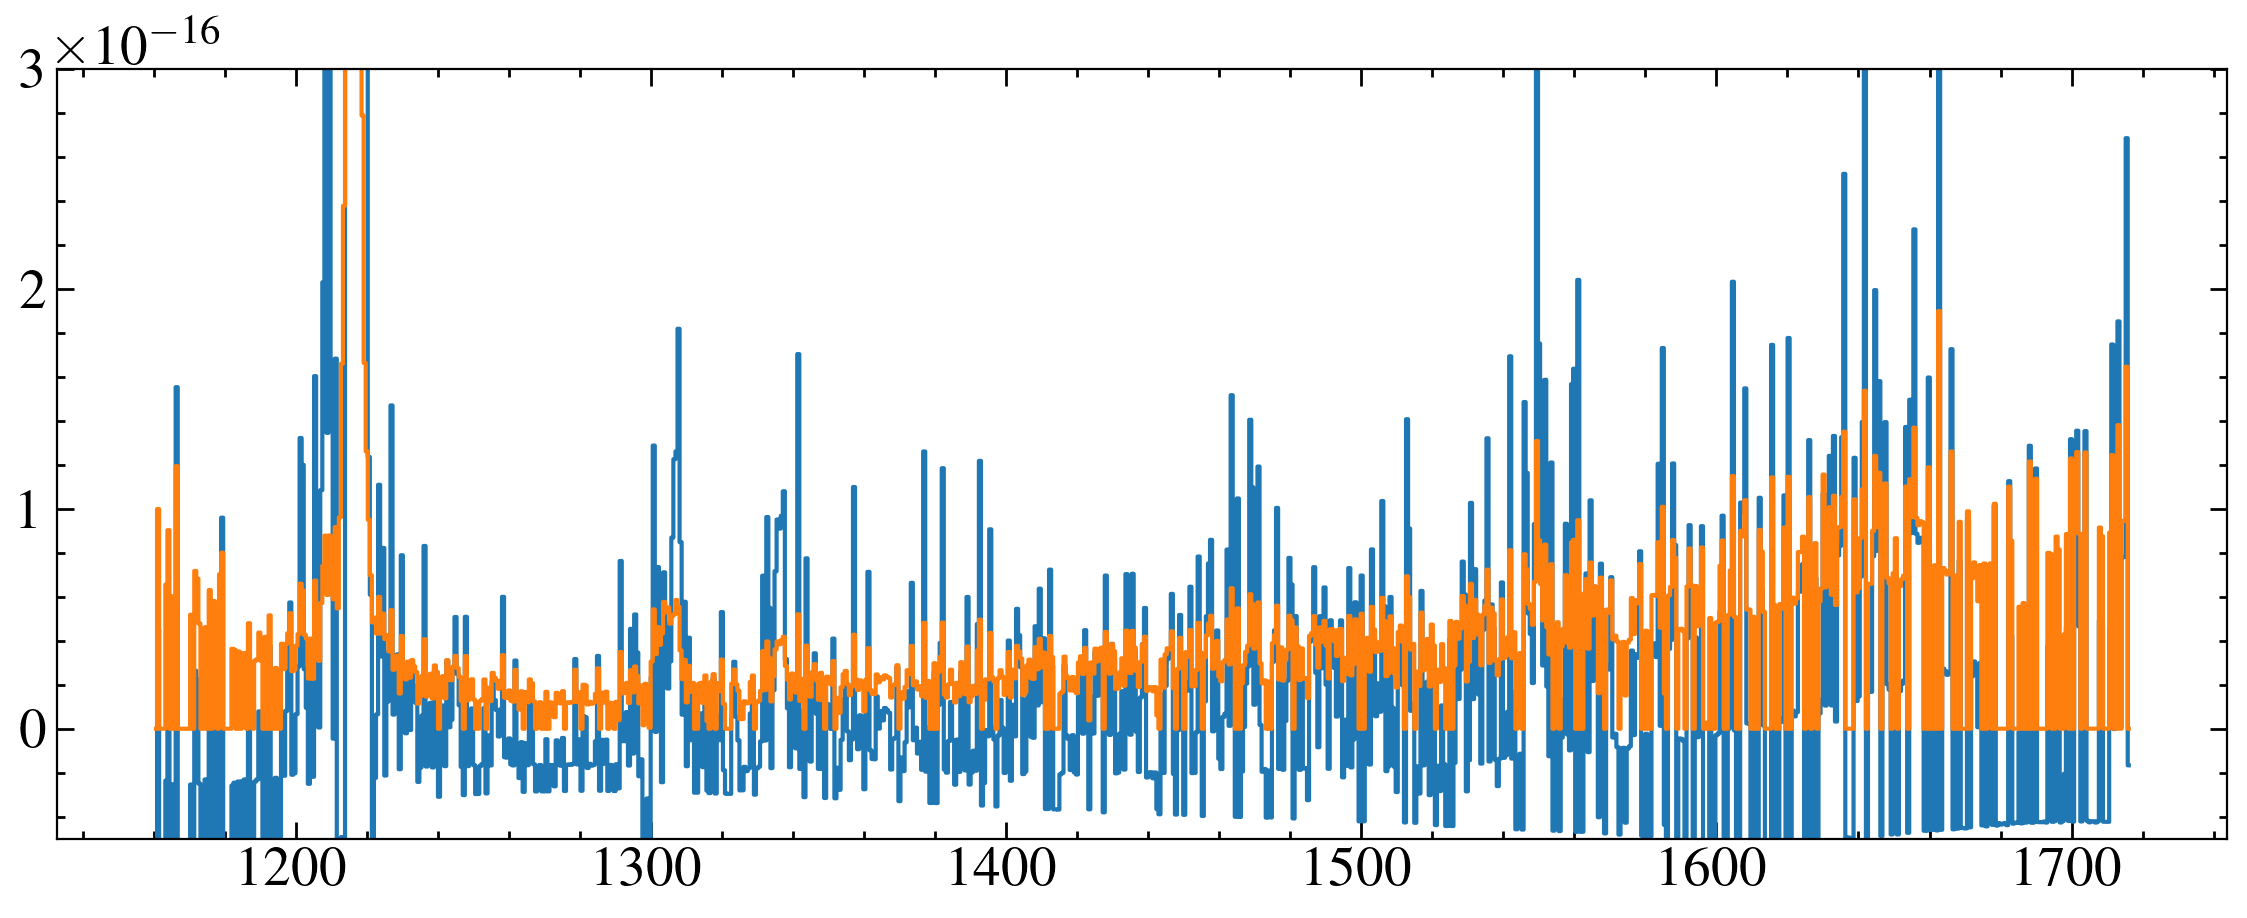

76.25582


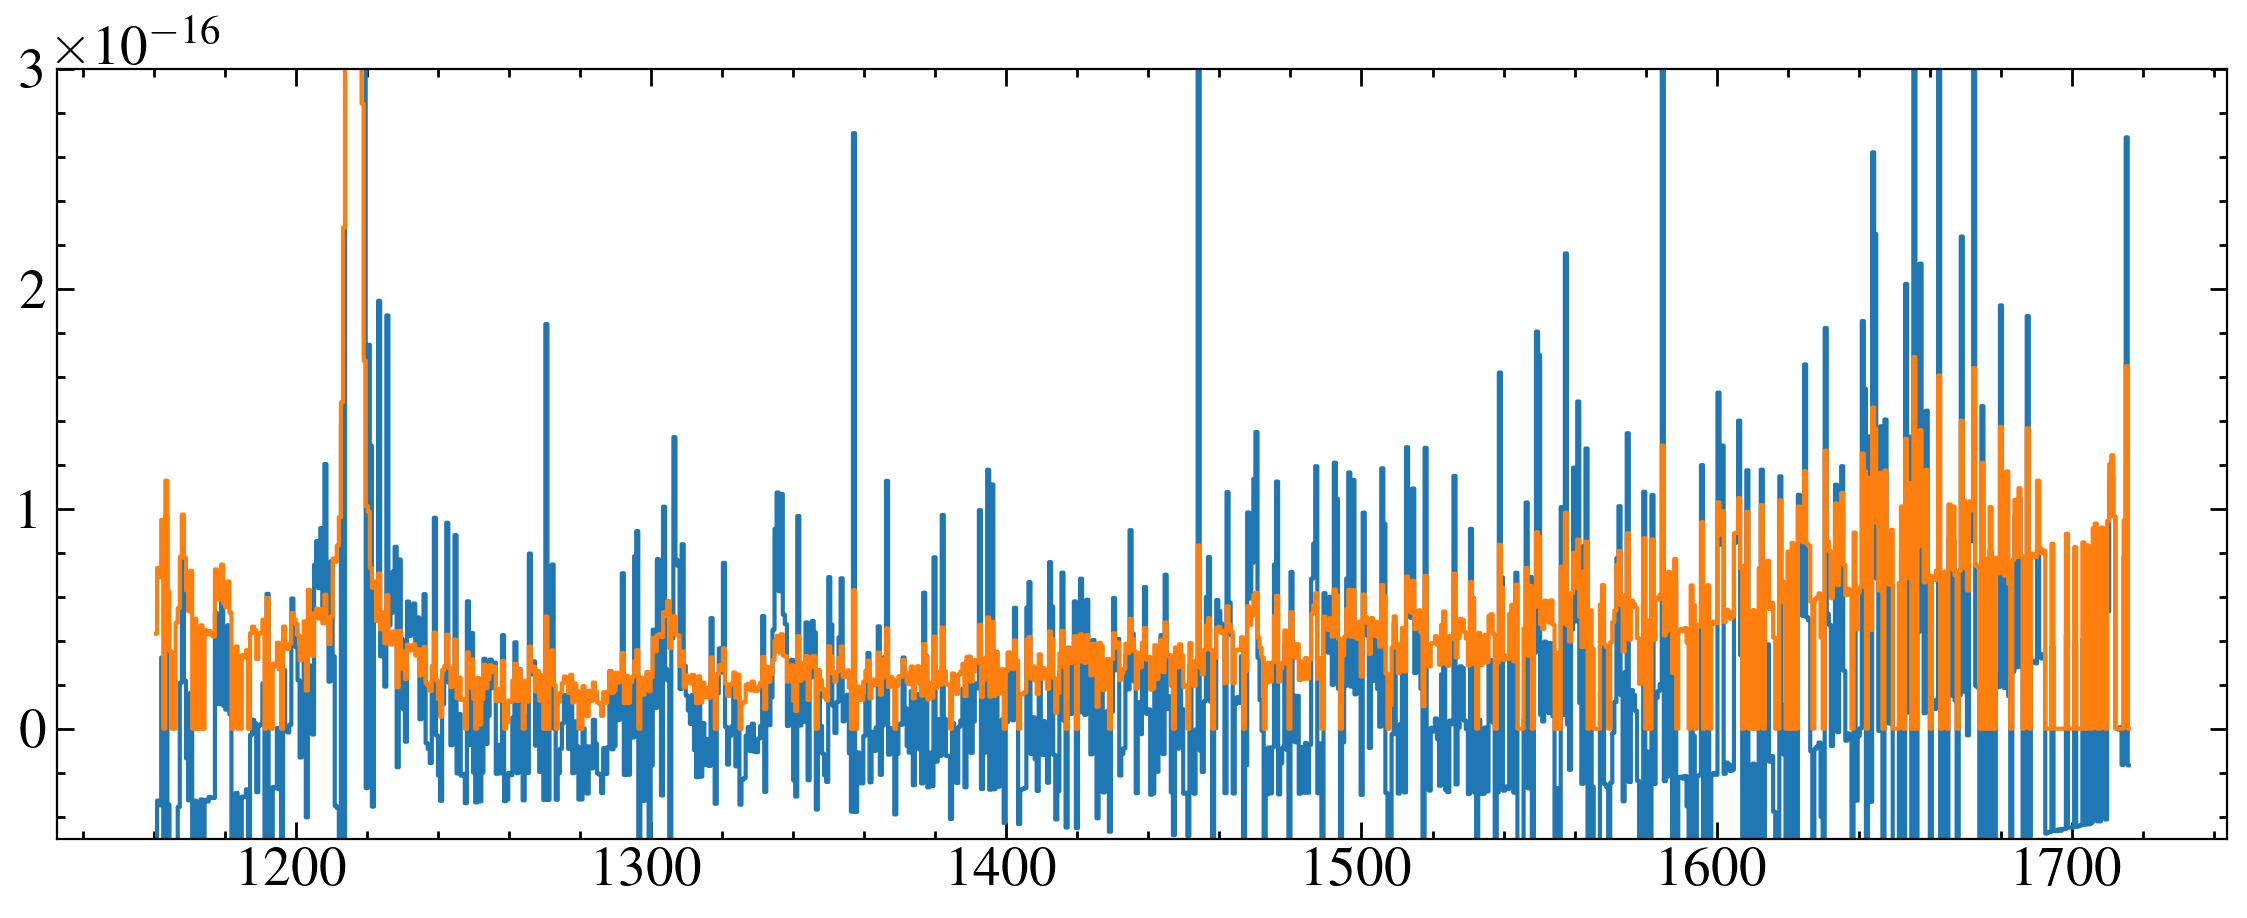

In [94]:
xs = [370,370,371]
ys = [76, 76, 76]
for i, root in enumerate(['oeoo24010', 'oeoo24020', 'oeoo24030']):
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/{}_new_x1d.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
    a2center = get_a2center(xs[i],ys[i], tracegrid)
    
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=10)#, bksmode='off')

    data = fits.getdata('reextractions/{}_new_x1d.fits'.format(root), 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.ylim(-0.5e-16, 3e-16)
    plt.show()


In [79]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [80]:
new_x1ds = glob.glob('reextractions/*240*x1d*')
new_x1ds

['reextractions/oeoo24030_new_x1d.fits',
 'reextractions/oeoo24020_new_x1d.fits',
 'reextractions/oeoo24010_new_x1d.fits']

(-2e-17, 2e-16)

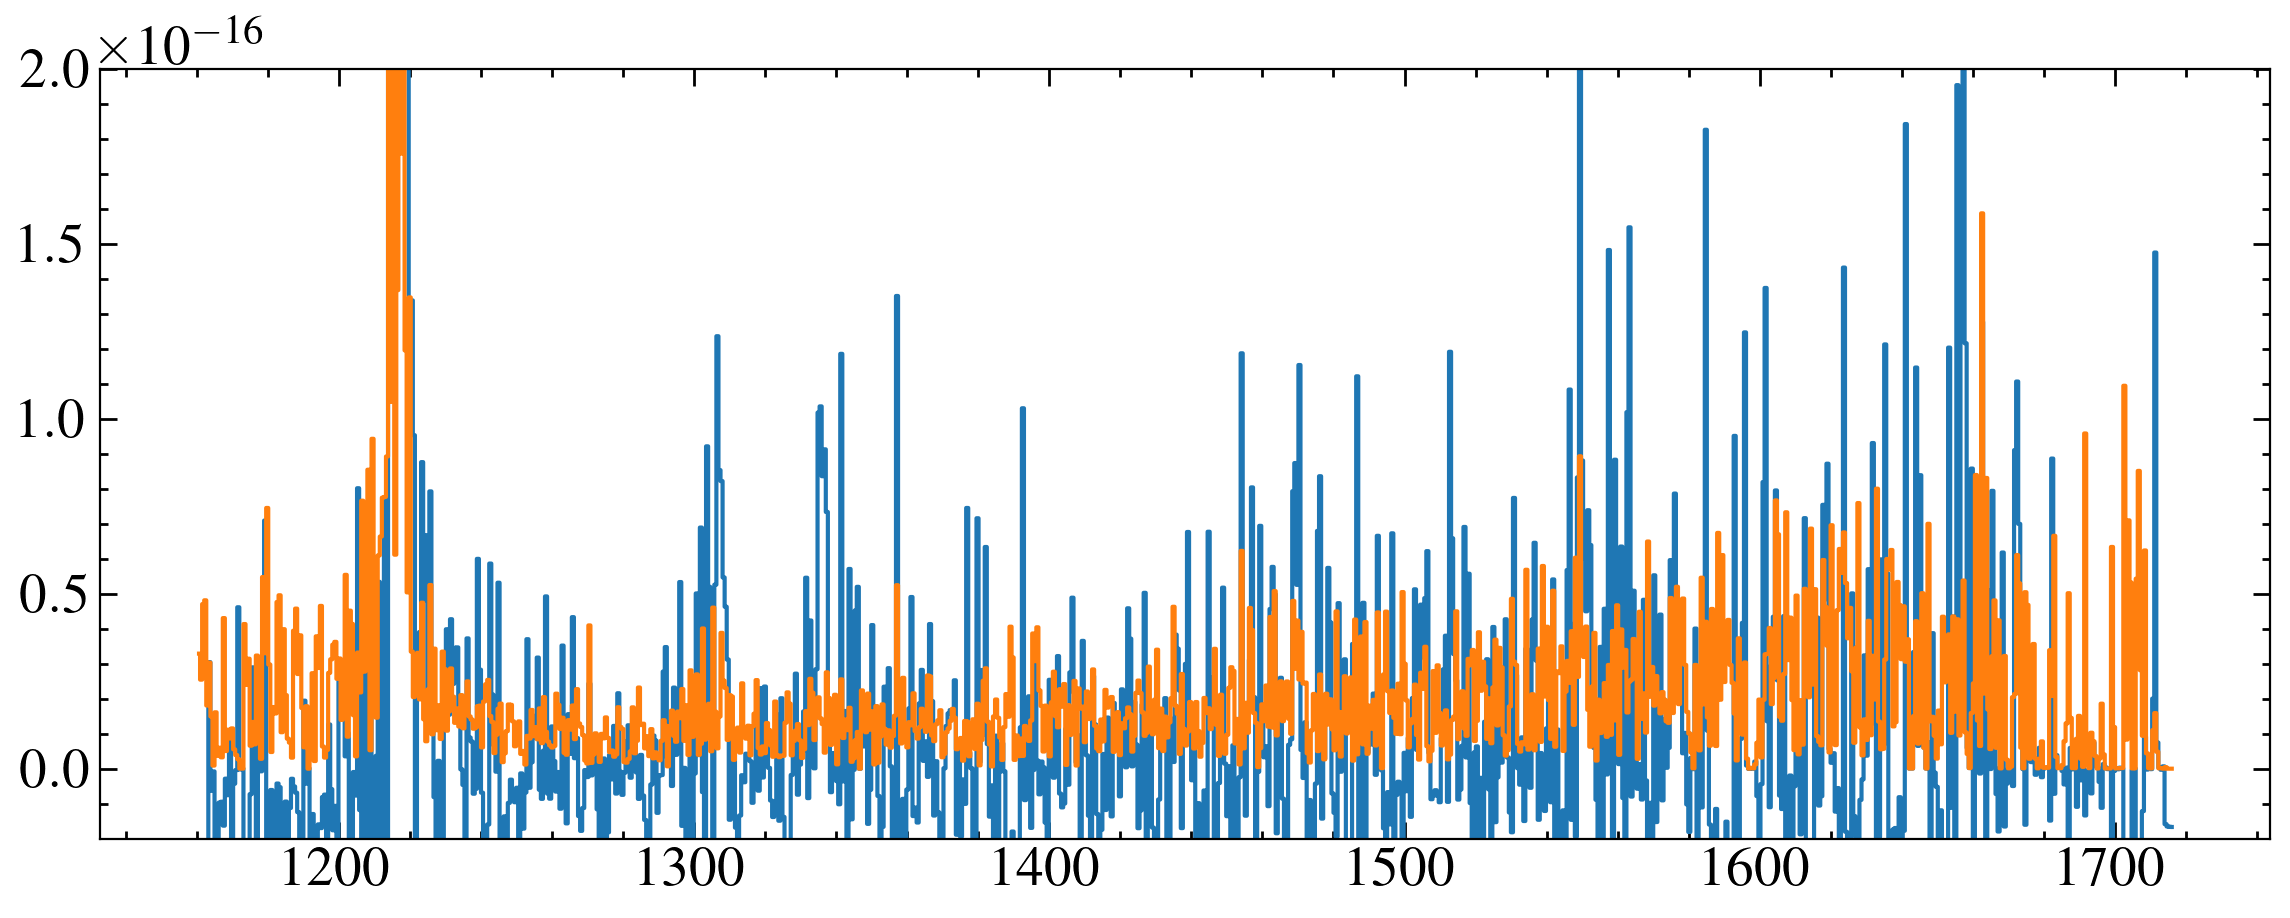

In [90]:
w_fuv = []
f_fuv = []
e_fuv = []

n=0
for x in new_x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        n +=1

f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)

plt.step(w_fuv, f_fuv, where='mid')
plt.step(w_fuv, e_fuv, where='mid')
plt.ylim(-2e-17, 2e-16)

(-2e-17, 2e-16)

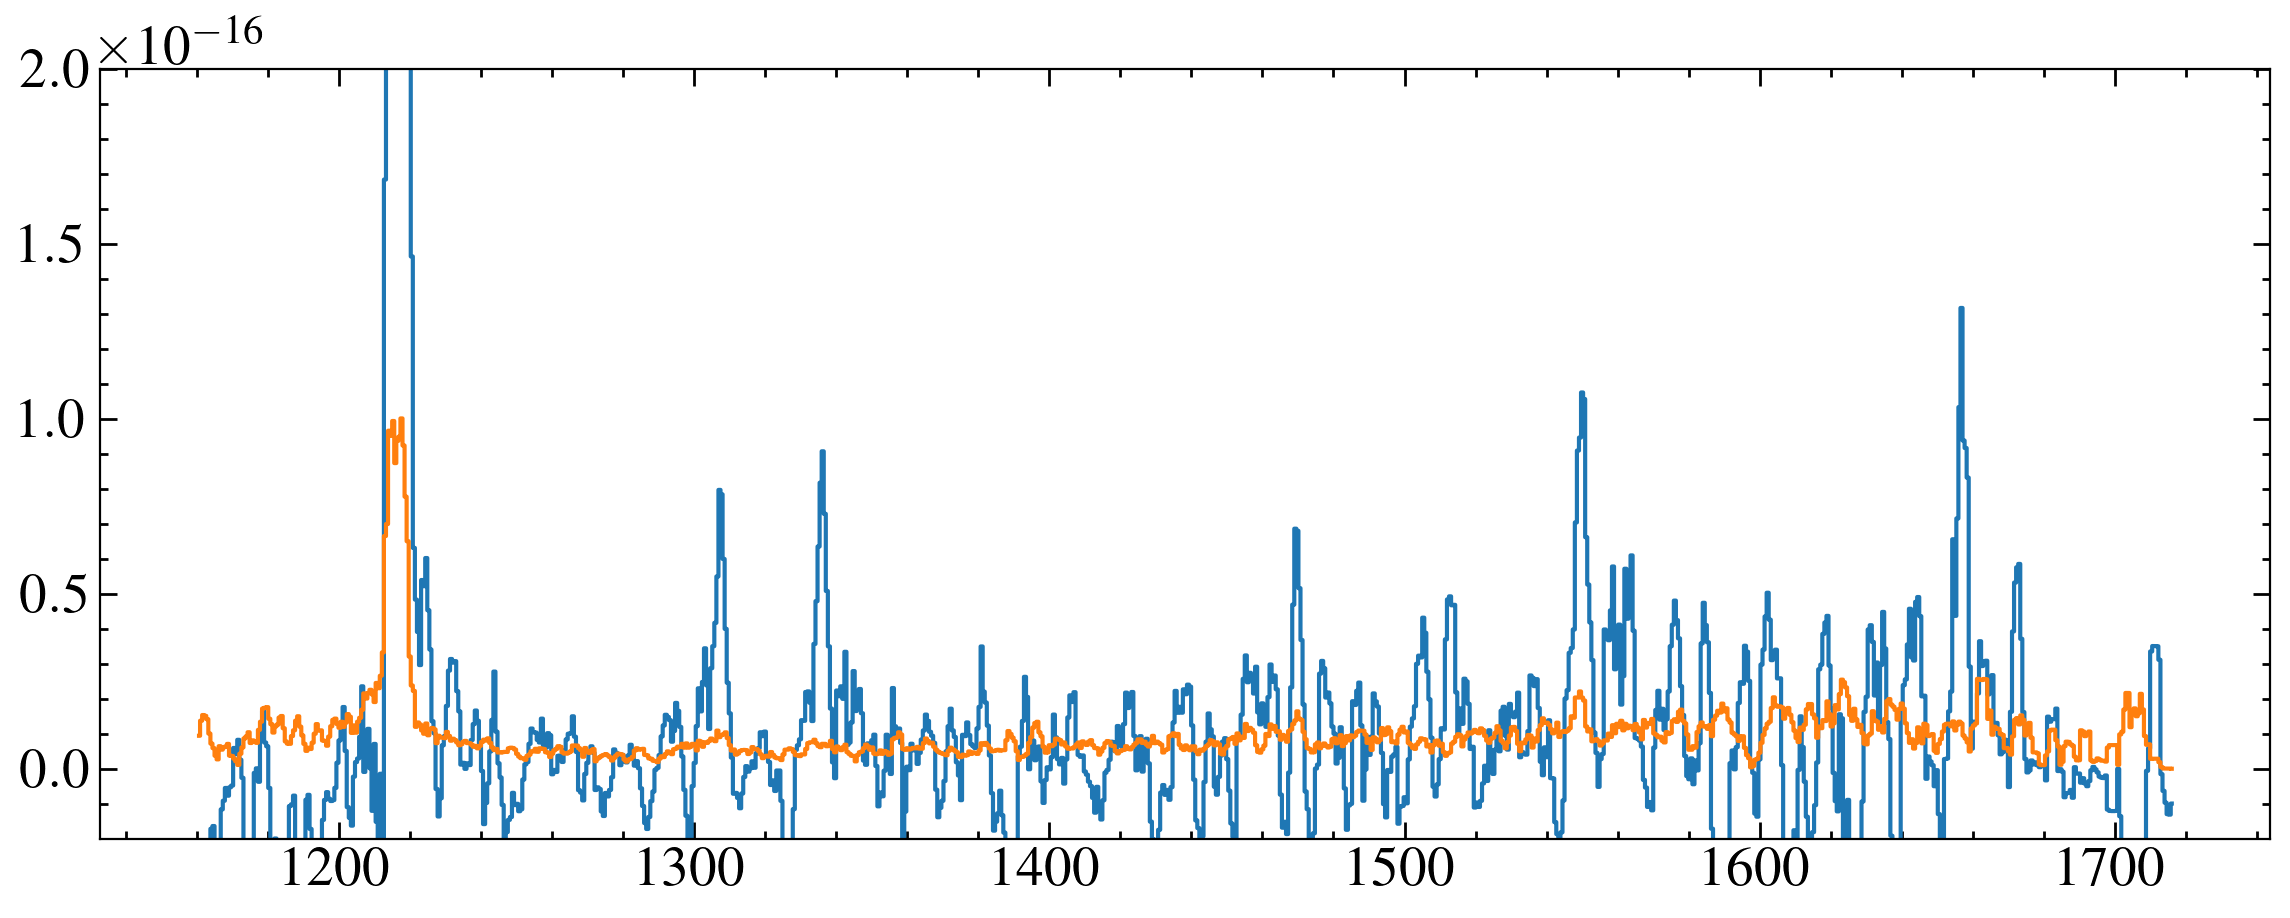

In [89]:
fi = convolve(f_fuv,  Box1DKernel(5))
ei = convolve(e_fuv,  Box1DKernel(5))/5**0.5
plt.step(w_fuv, fi, where='mid')
plt.step(w_fuv, ei, where='mid')
plt.ylim(-2e-17, 2e-16)

In [14]:
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1700) & (w <3130)
        w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]

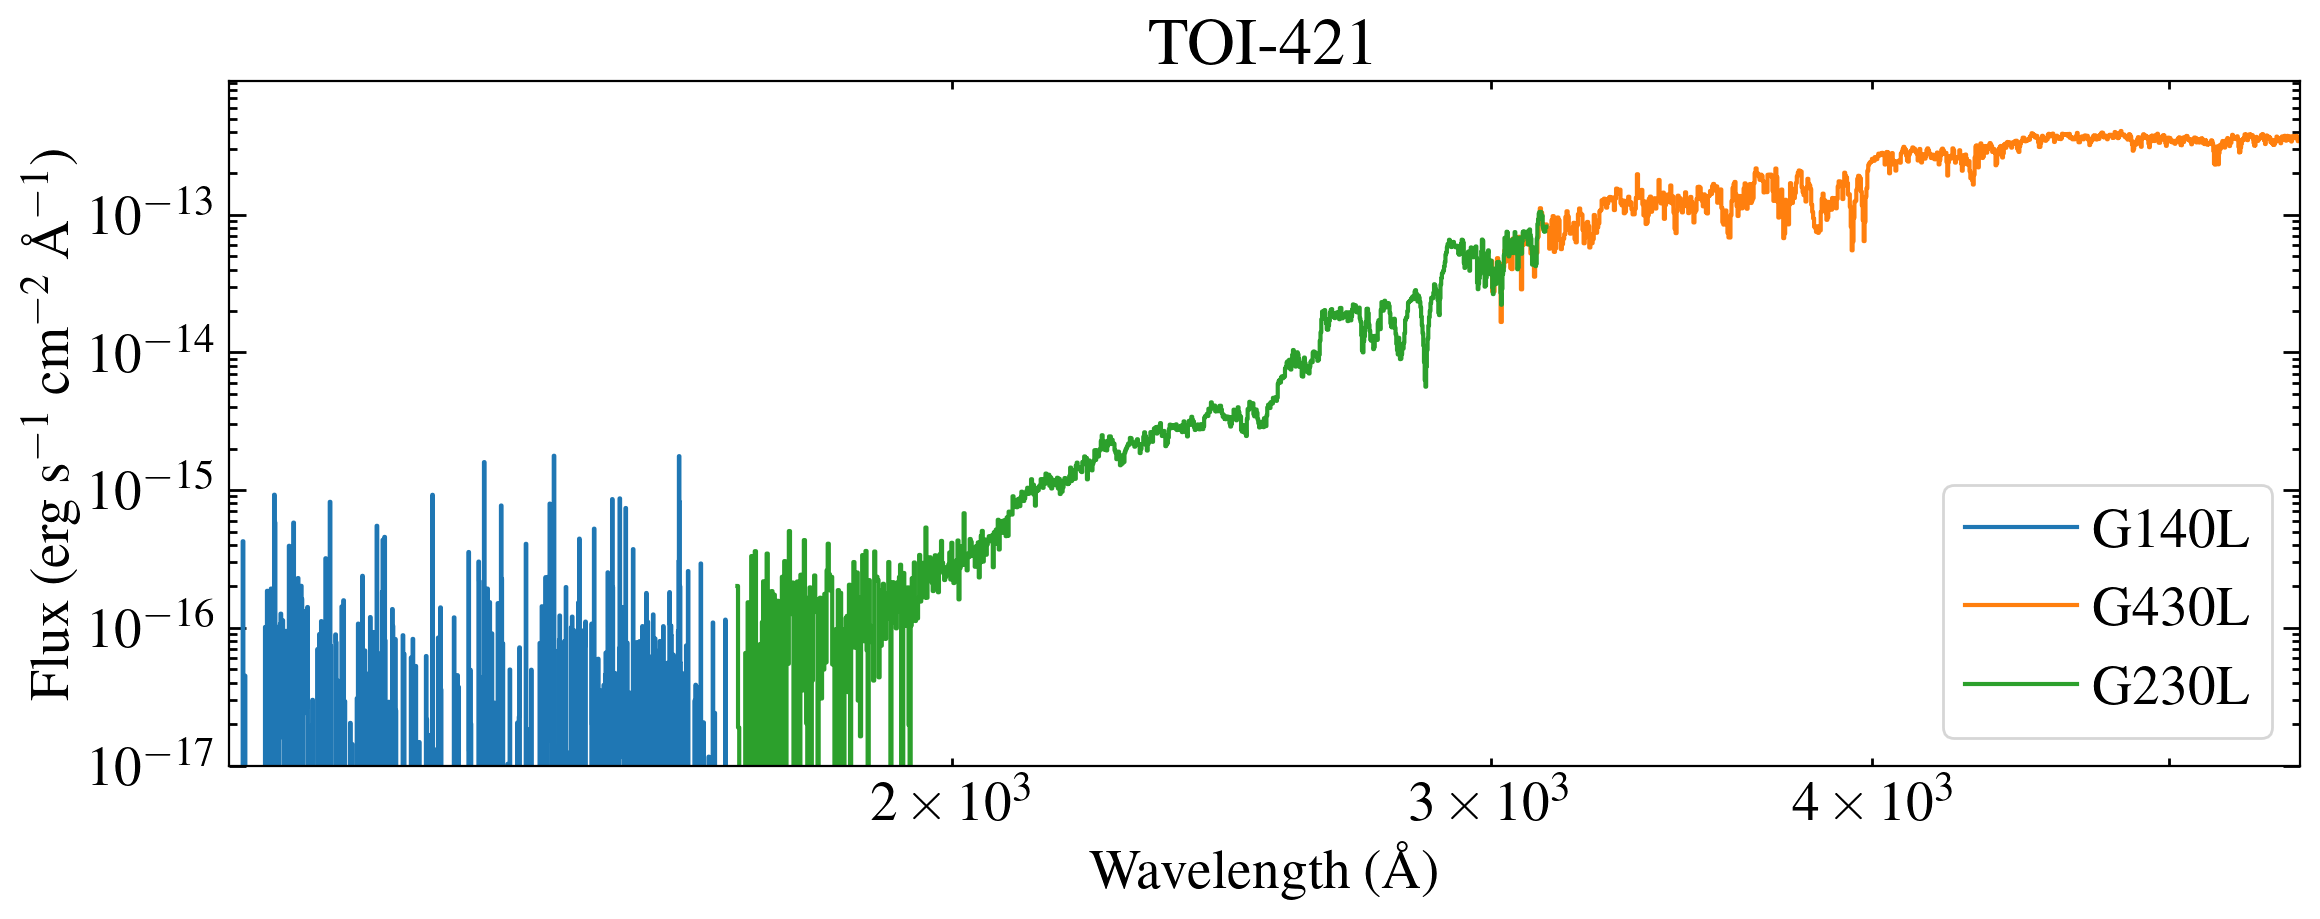

In [15]:
plt.figure(figsize=(12, 5))

plt.step(w_fuv, f_fuv, where='mid', label ='G140L')
plt.step(w_opt, f_opt, where='mid', label='G430L')
plt.step(w_nuv, f_nuv, where='mid', label='G230L')


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-17)
plt.xlim(1160, 5520)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('TOI-421')
plt.tight_layout()
plt.savefig('plots/toi-421_ql.pdf')
plt.savefig('plots/toi-421_ql.png', facecolor='w')

In [16]:
import importlib
import prepare_stis
importlib.reload(prepare_stis)

<module 'prepare_stis' from '/home/david/work/meats/SEDs/prepare_stis.py'>

/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/stats/funcs.py:702: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


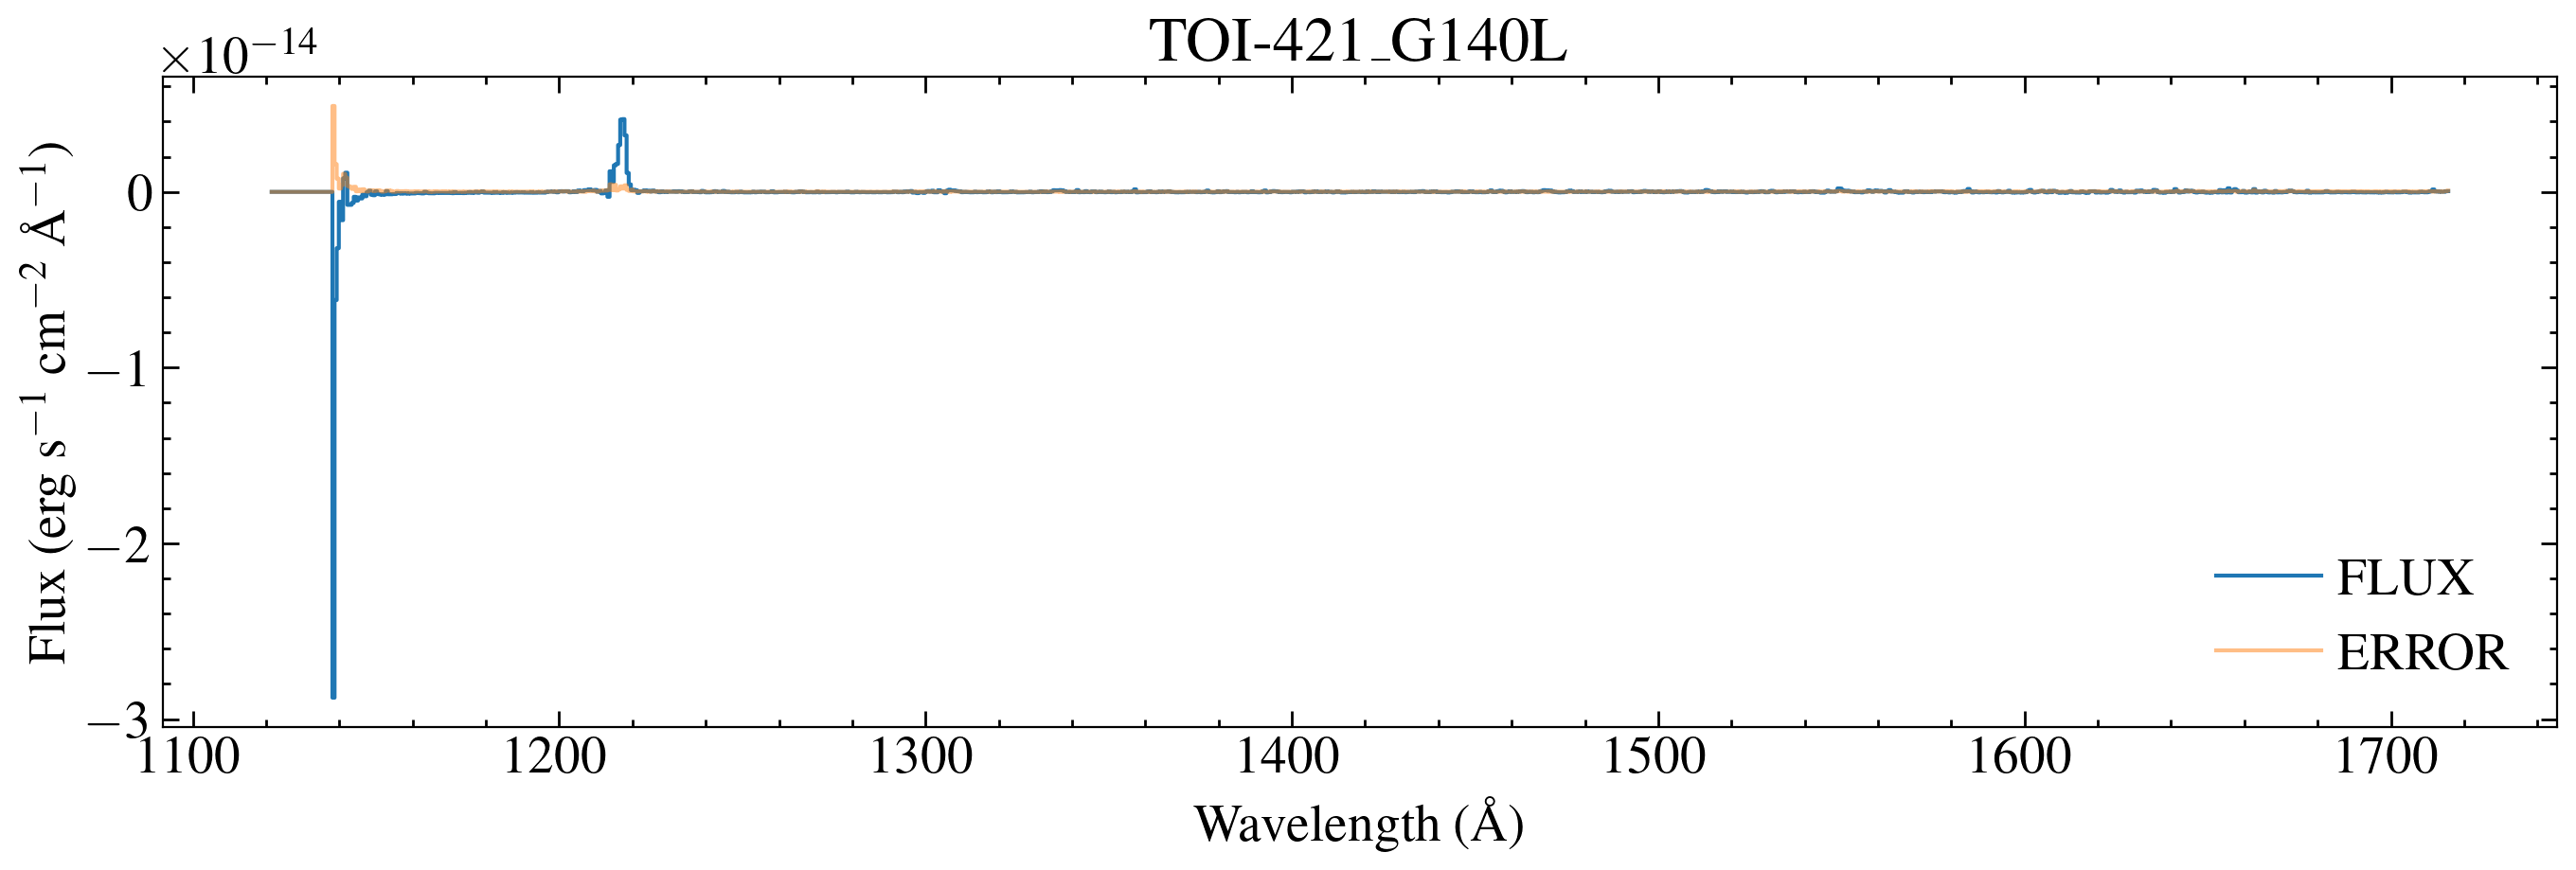

Spectrum saved as hlsp_muscles_hst_stis_toi-421_g140l_v1_component-spec.fits


/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/stats/funcs.py:702: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


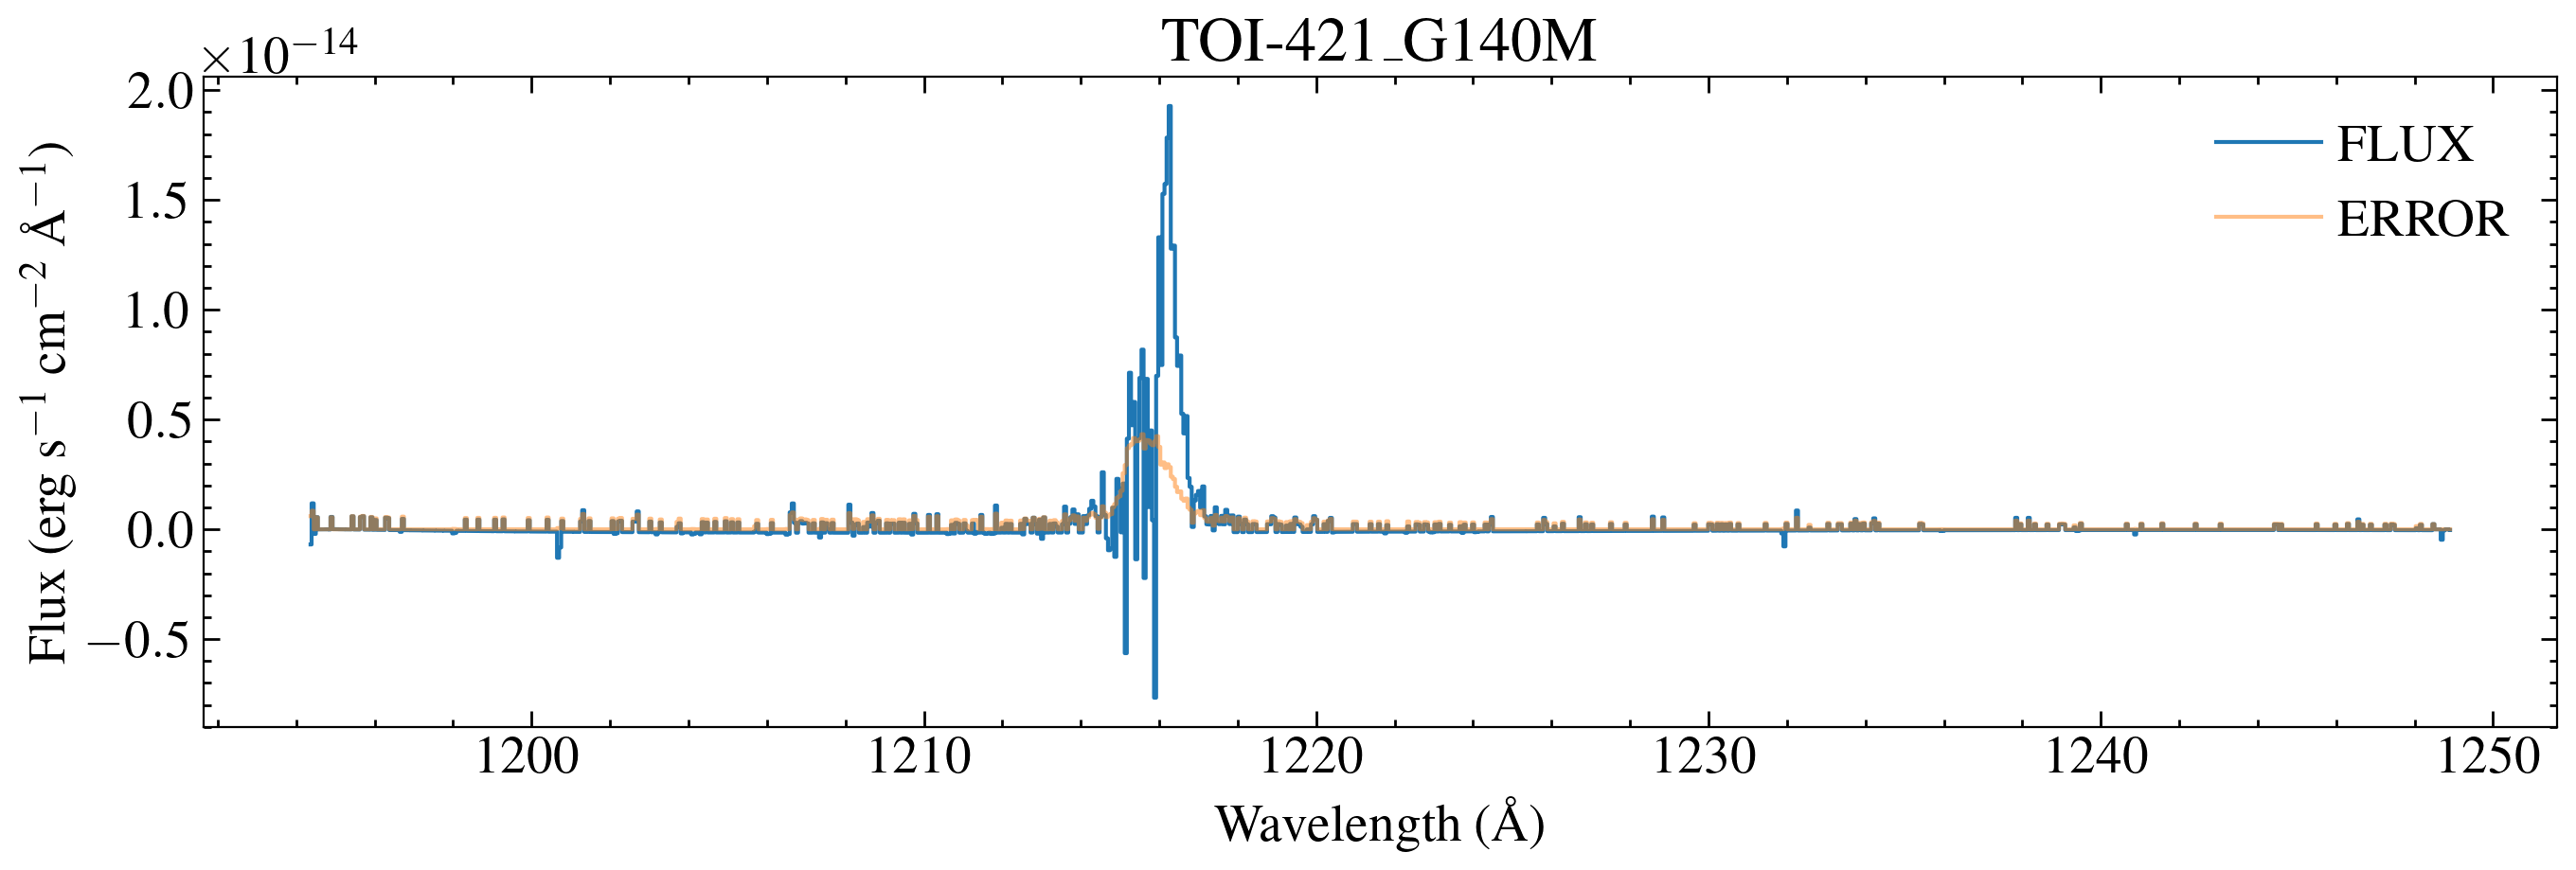

Spectrum saved as hlsp_muscles_hst_stis_toi-421_g140m_v1_component-spec.fits


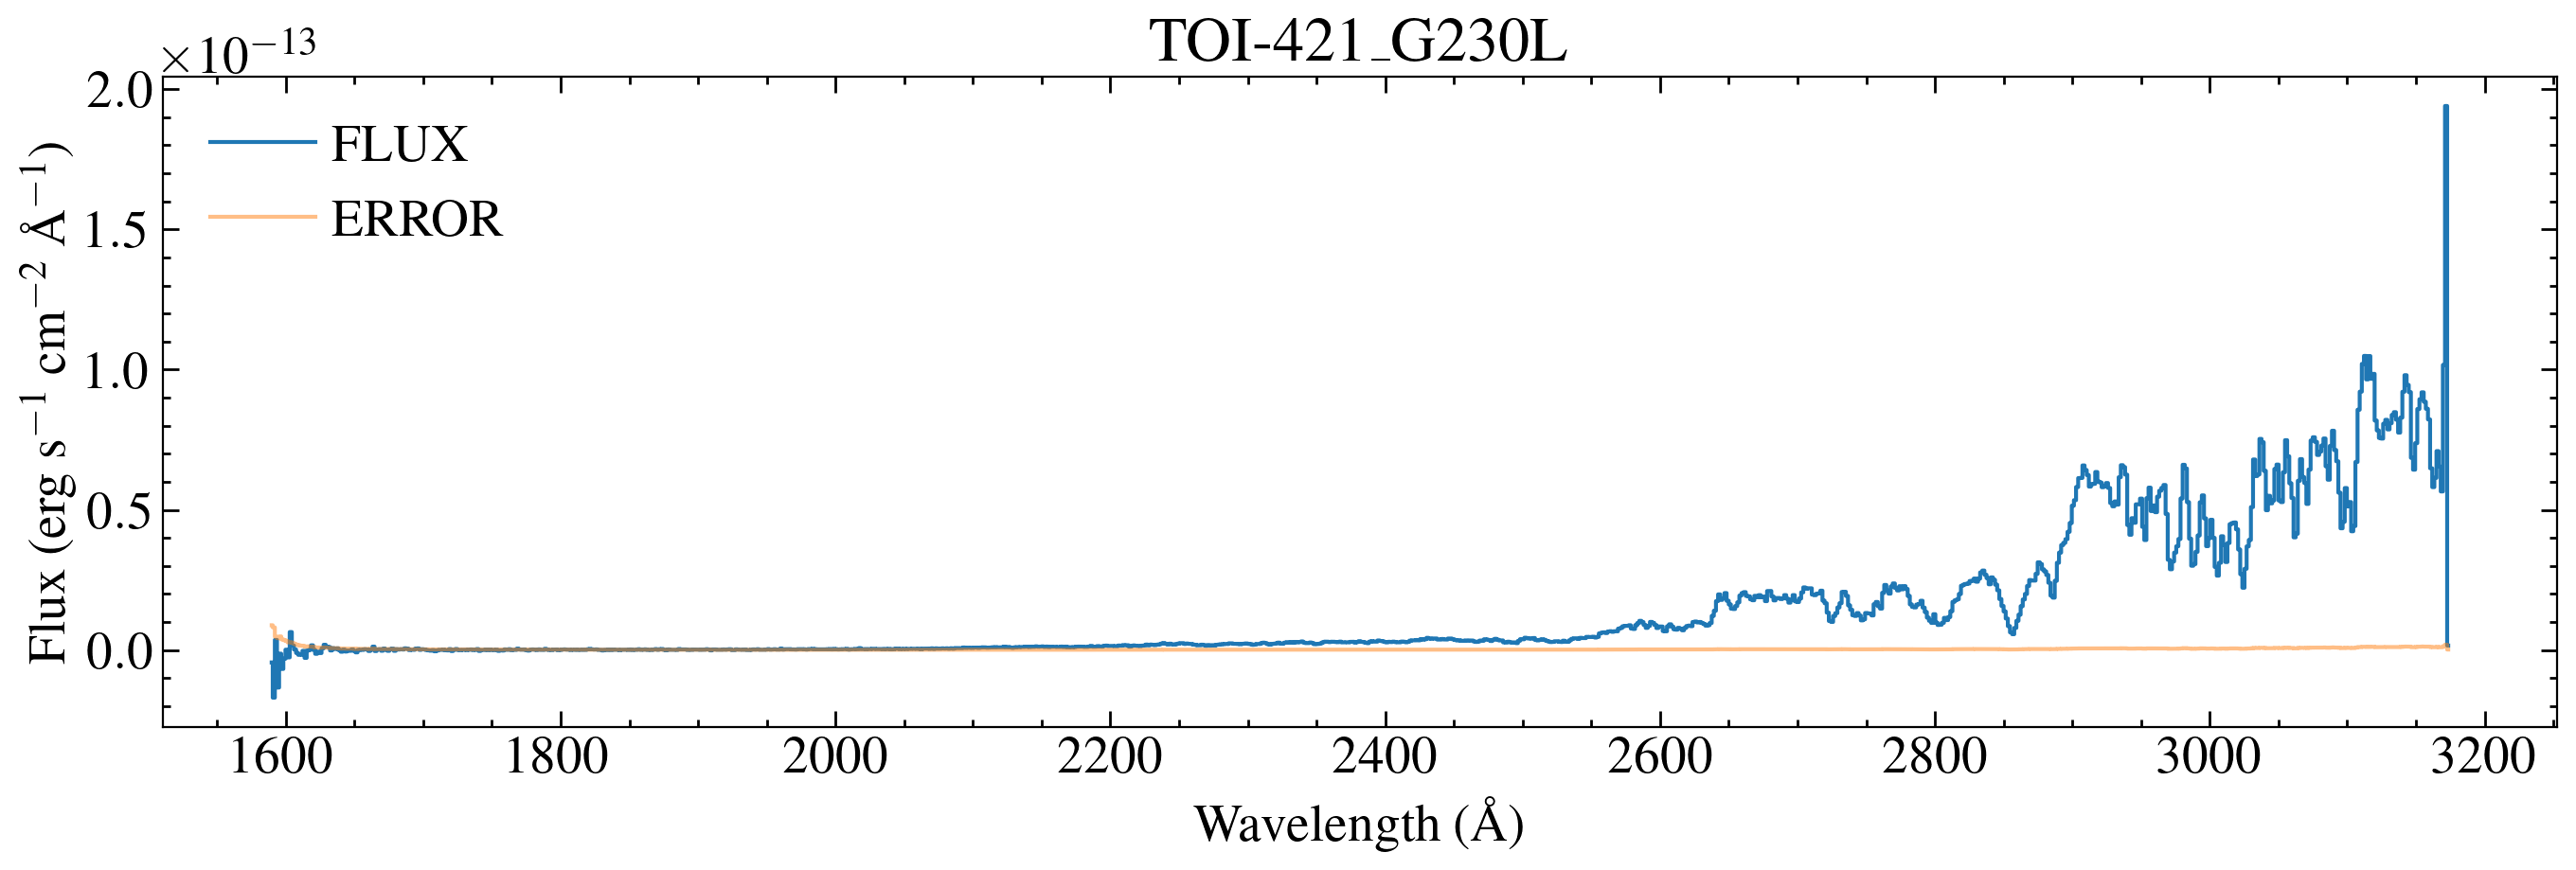

Spectrum saved as hlsp_muscles_hst_stis_toi-421_g230l_v1_component-spec.fits


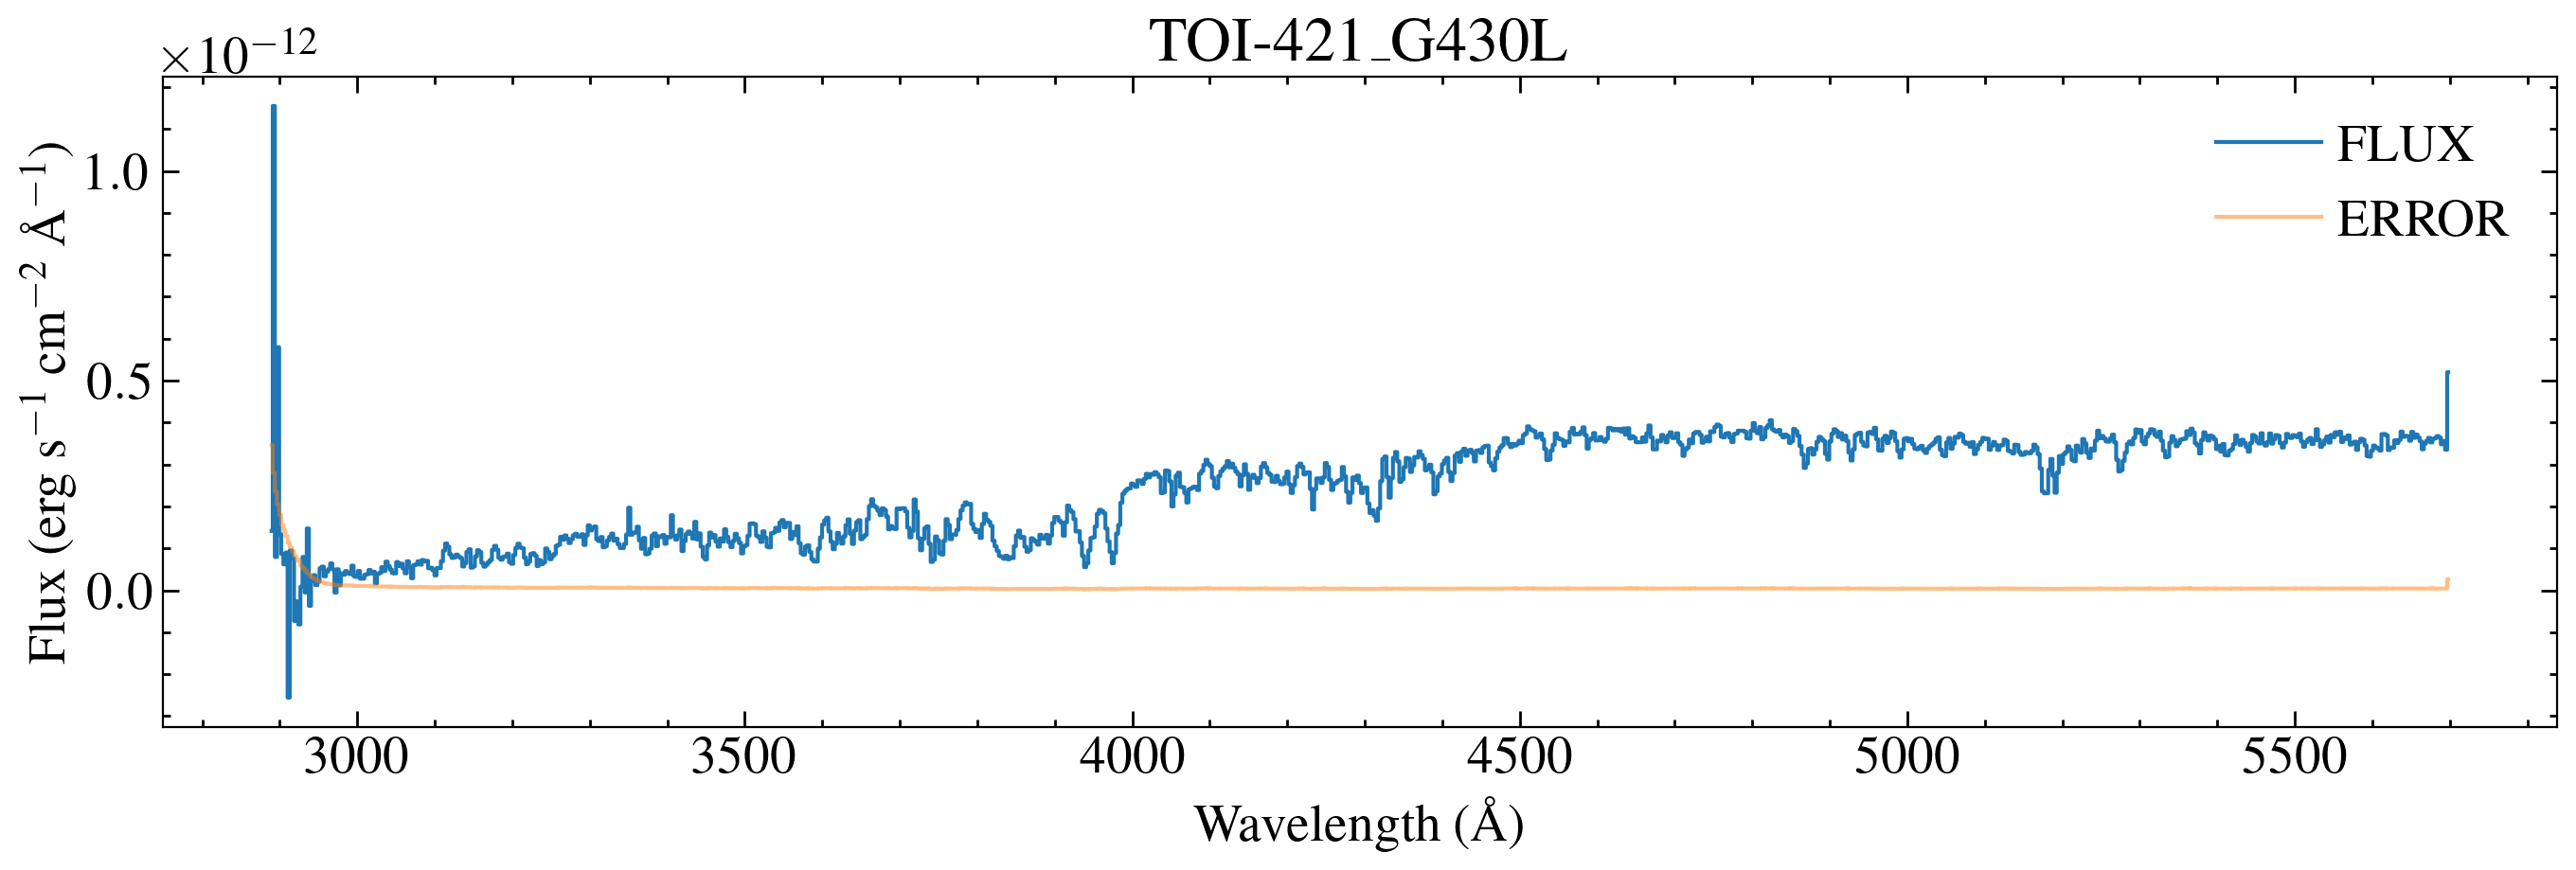

Spectrum saved as hlsp_muscles_hst_stis_toi-421_g430l_v1_component-spec.fits


In [95]:
# make_stis_spectum(x1dpath, version,savepath = '', plot=False, save_ecsv=False, save_fits=False, return_data=False, return_gratings = False, normfac=1.0, sx1 = True)
goodpath = '{}/spectra_for_hlsp/'.format(path) #path where the final spectra are.
savepath = 'draft_hlsp/toi-421/'
version = 1
hlsp = 'meats_hlsp_info.csv'
prepare_stis.make_stis_spectrum(goodpath, version, hlsp, savepath=savepath, plot=True, save_ecsv=False, save_fits=True, star='TOI-421')

In [18]:
fits.getheader('draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g140l_v1_component-spec.fits', 0)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'HST     '                                                            
INSTRUME= 'STIS    '                                                            
GRATING = 'G140L   '                                                            
APERTURE= '52X0.2  '                                                            
TARGNAME= 'TOI-421 '                                                            
RA_TARG =    81.85321251806999                                                  
DEC_TARG=      -14.27663930912                                                  
PROPOSID=                16701                                                  
HLSPNAME= 'MUSCLES Extension

draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g140m_v1_component-spec.fits
draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g230l_v1_component-spec.fits
G230L
[1700, 3160]
draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g430l_v1_component-spec.fits
G430L
[3160, 5690]
draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g140l_v1_component-spec.fits
G140L
[1160, 1650]


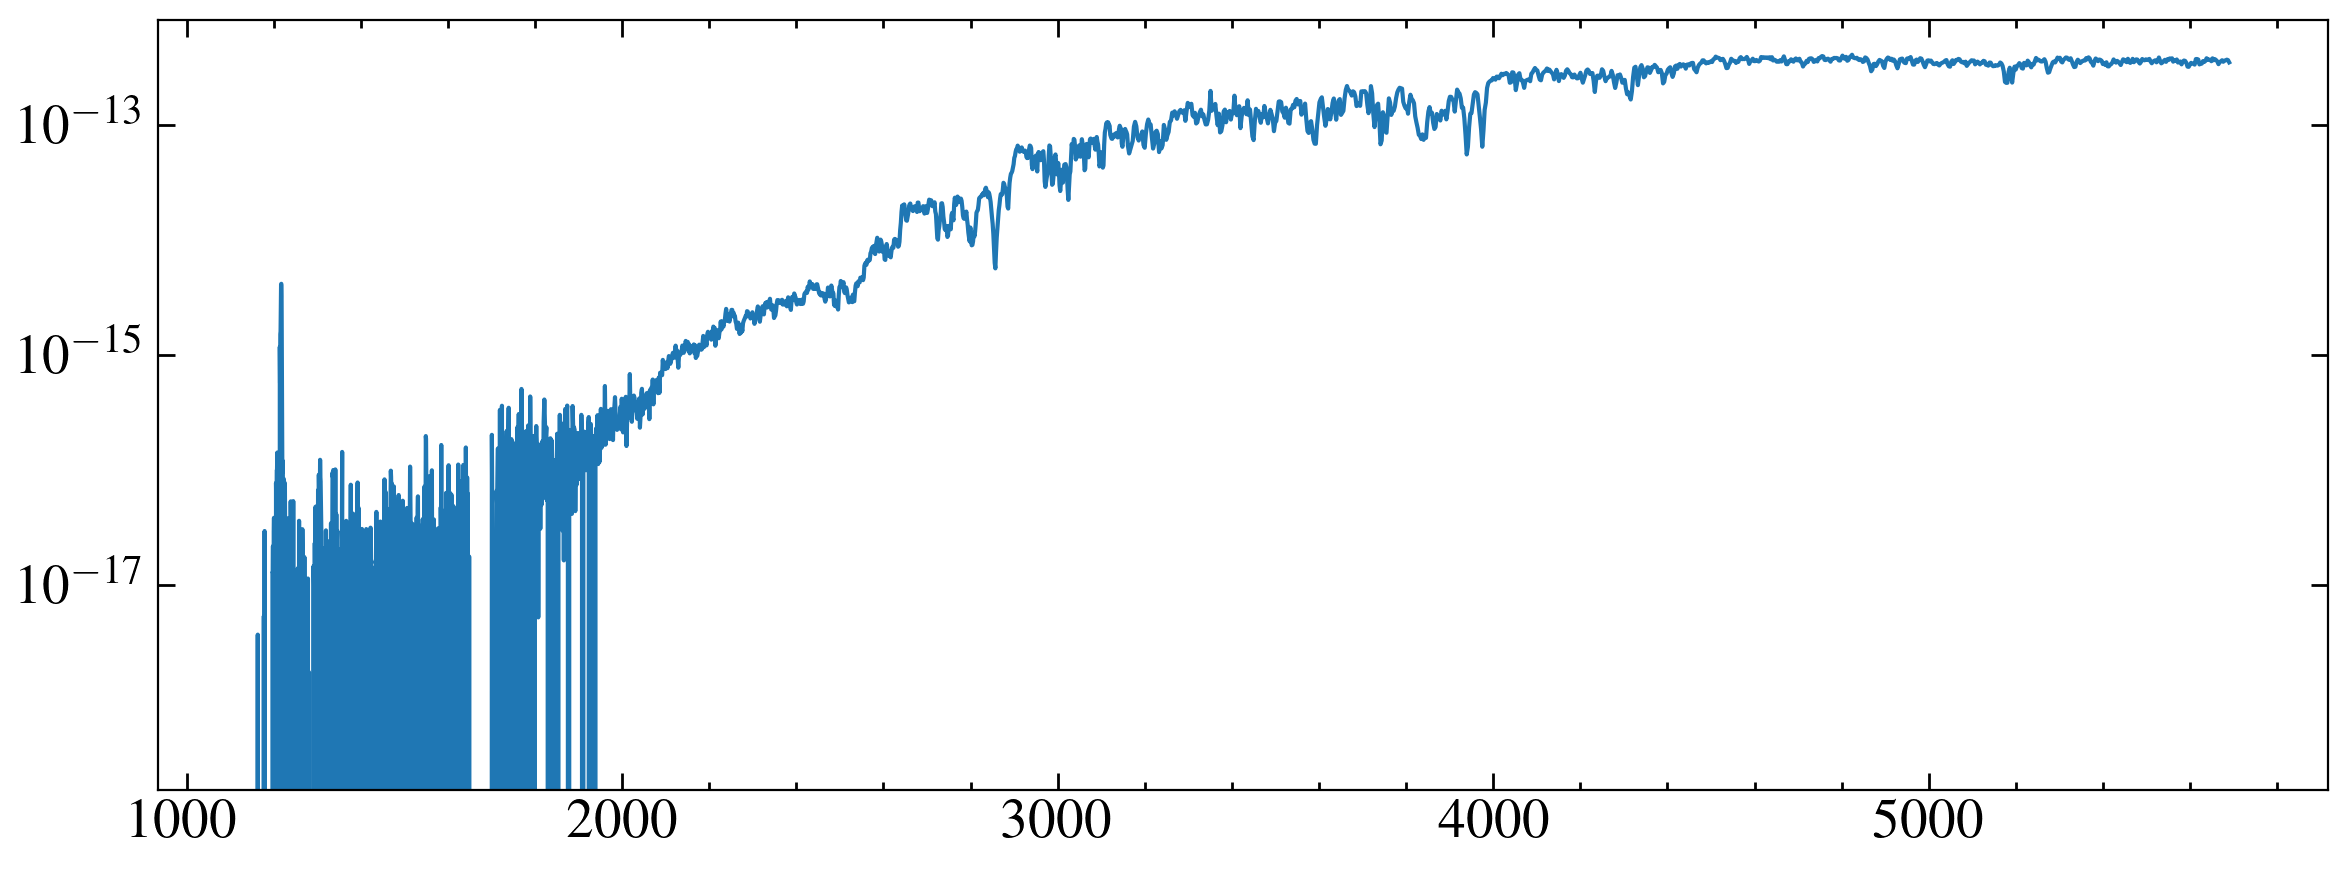

In [101]:
#good spectral ranges, incorporate into SED builder later
goodbands = dict(G140L=[1160,1650], G230L=[1700, 3160], G430L=[3160, 5690])
specs = glob.glob('draft_hlsp/toi-421/*stis*fits')
# specs
w_stis = np.array([], dtype=float)
f_stis = np.array([], dtype=float)
e_stis = np.array([], dtype=float)

gratings = []
for spec in specs:
    print (spec)
    grating = fits.getheader(spec, 0)['GRATING']
    if grating != 'G140M': #only used for Lya fitting
        print (grating)
        data = fits.getdata(spec, 1)
        band = goodbands[grating]
        print(band)
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = (w > band[0]) & (w < band[1])
        w, f, e = w[mask], f[mask], e[mask]
        w_stis = np.hstack((w_stis, w))
        f_stis = np.hstack((f_stis, f))   
        e_stis = np.hstack((e_stis, e))  
args = np.argsort(w_stis)
w_stis, f_stis, e_stis = w_stis[args], f_stis[args], e_stis[args]
plt.plot(w_stis, f_stis)
plt.yscale('log')

Testing the Sun as a proxy, seeing how scaling by distance works out

In [20]:
data = Table.read('Solar_1au_sed.ecsv')
w_sol, f_sol = data['WAVELENGTH'], data['FLUX']
# plt.plot(w_sol, f_sol)

4.201288800154684e-15


(1e-19, 9.475542432898187e-12)

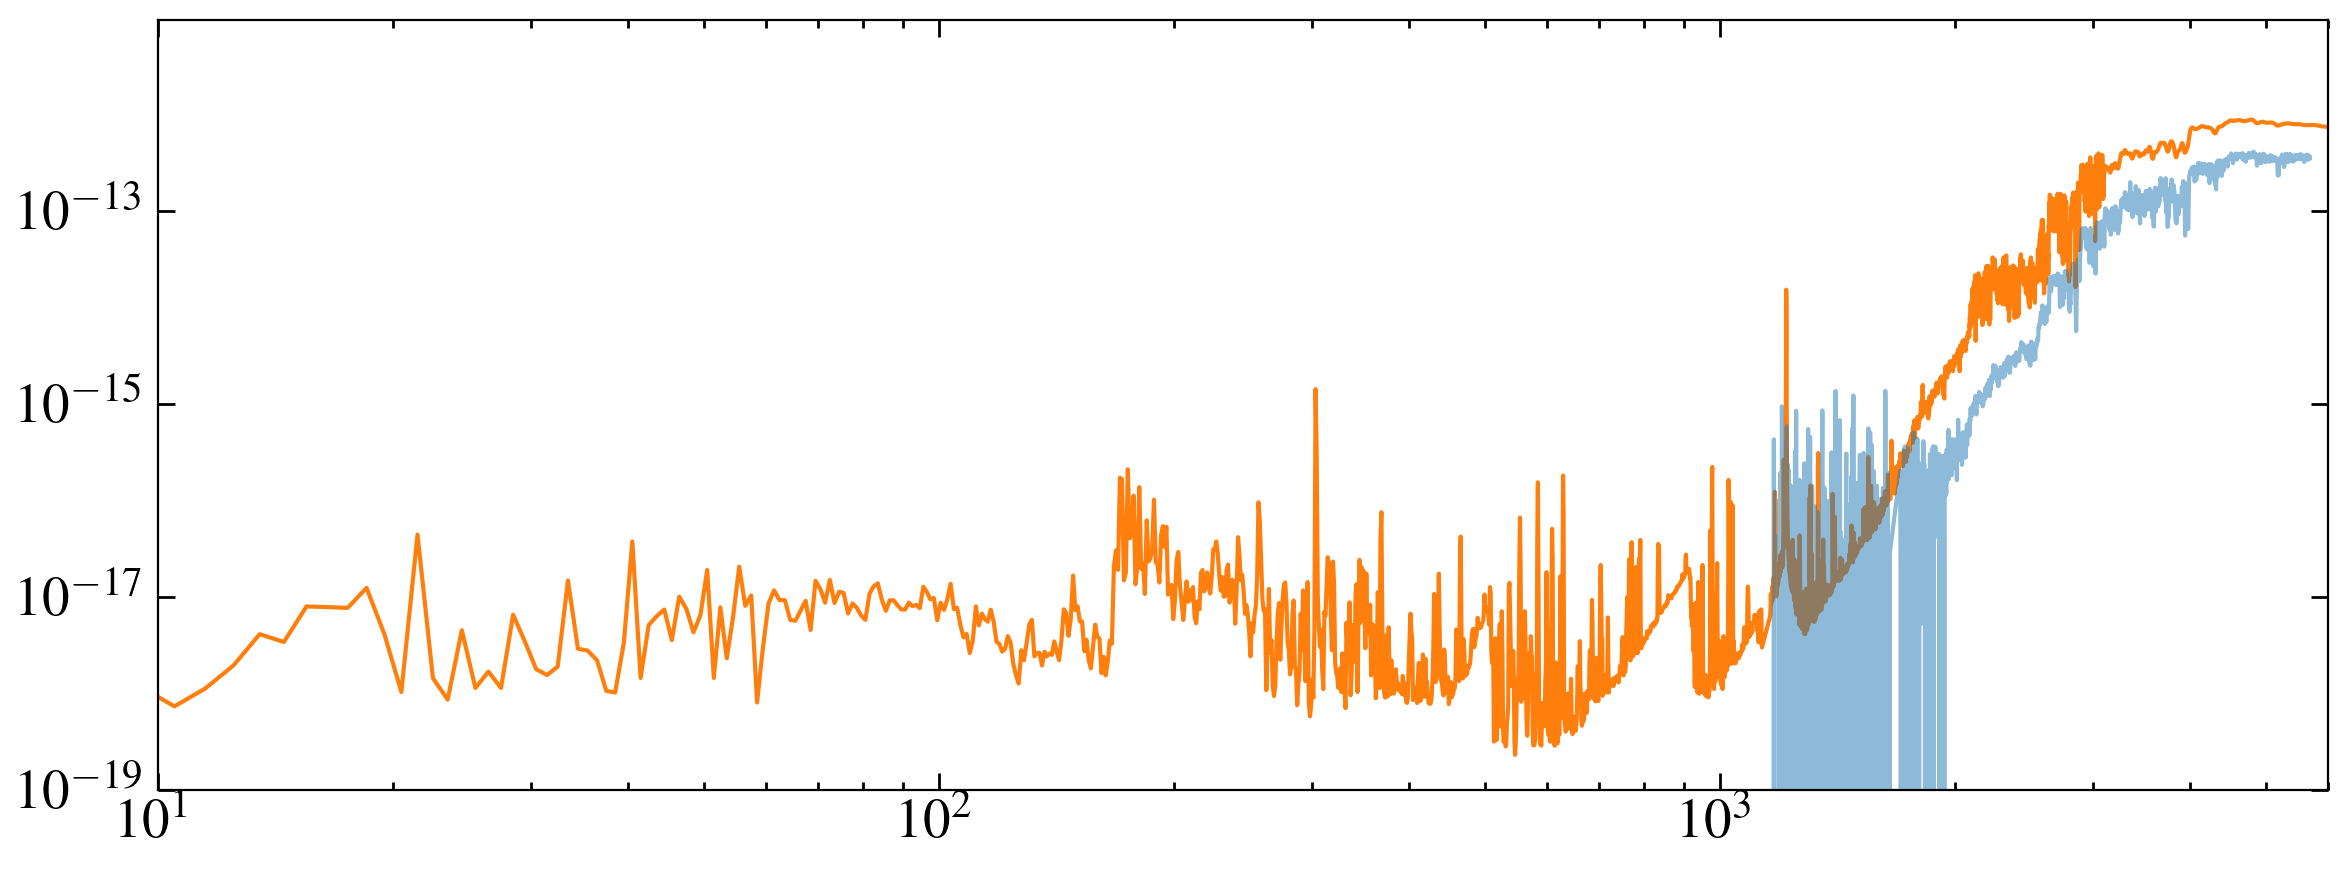

In [21]:
d_421 = 74.7969*u.pc
proxyscale = (((1*u.au).to(u.pc)) / d_421)**2
print(proxyscale)
plt.plot(w_stis, f_stis, alpha=0.5)
plt.plot(w_sol, f_sol*proxyscale, zorder=-1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10, 6000)
plt.ylim(1e-19)


What about setting the intergrated FUV flux to be the same?

2.105643831137689e-15 6.3598337
3.3108473031215106e-16


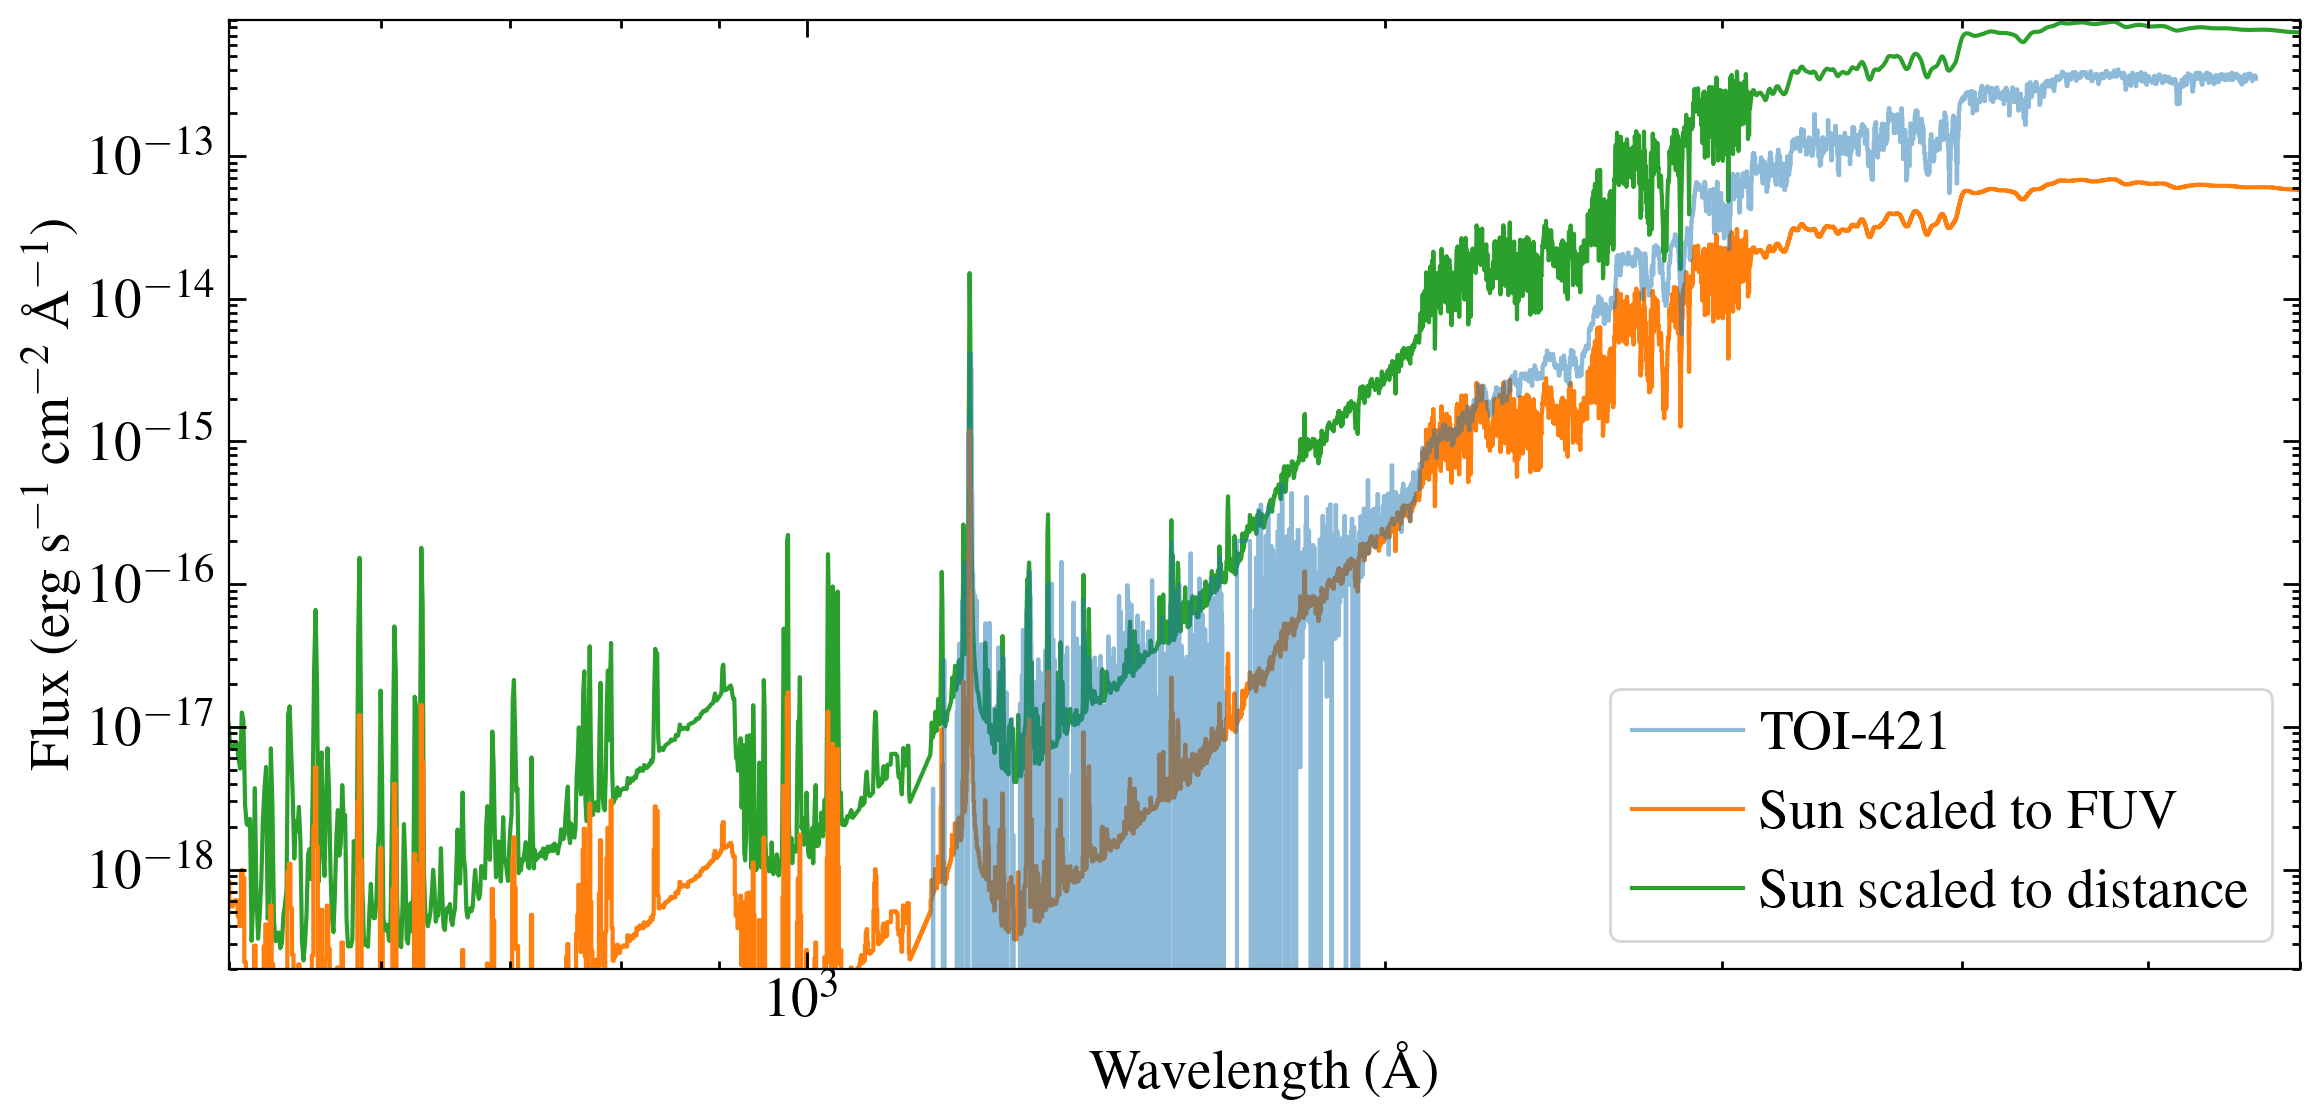

In [102]:
starmask = (w_stis > 1160) & (w_stis < 1210) | (w_stis > 1220) & (w_stis < 1700)#cut out lya 
sunmask = (w_sol > 1160) & (w_sol < 1210) | (w_sol > 1220) & (w_sol < 1700)#cut out lya
fuvstar = np.trapz(f_stis[starmask], w_stis[starmask])
fuvsol = np.trapz(f_sol[sunmask], w_sol[sunmask])
print(fuvstar, fuvsol)
fuv_ratio = fuvstar/fuvsol
print(fuv_ratio)

fig, ax= plt.subplots(figsize =(12, 6))

plt.step(w_stis, f_stis, alpha=0.5, where='mid', label = 'TOI-421')
plt.step(w_sol, f_sol*fuv_ratio, zorder=-1, where='mid', label='Sun scaled to FUV')
plt.plot(w_sol, f_sol*proxyscale, zorder=-2, label='Sun scaled to distance')

plt.yscale('log')
plt.xscale('log')
plt.xlim(500, 6000)
plt.ylim(2e-19, 9e-13)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
# plt.title('TOI-421')



plt.tight_layout()
plt.savefig('plots/toi-421_fuvsun.pdf')
plt.savefig('plots/toi-421_fuvsun.png', facecolor='w')


or NUV

In [23]:
# starmask = (w_stis > 1700) & (w_stis < 3000) 
# sunmask = (w_sol > 1700) & (w_sol < 3000) 
# nuvstar = np.trapz(f_stis[starmask], w_stis[starmask])
# nuvsol = np.trapz(f_sol[sunmask], w_sol[sunmask])
# print(nuvstar, nuvsol)
# nuv_ratio = nuvstar/nuvsol
# print(nuv_ratio)

# plt.step(w_stis, f_stis, alpha=0.5, where='mid')
# plt.step(w_sol, f_sol*nuv_ratio, zorder=-1,where='mid')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(100, 6000)
# plt.ylim(1e-19)

In [24]:
# print(fuv_ratio/nuv_ratio)
# print(fuv_ratio/proxyscale)

Similar ish. Maybe FUV, as NUV still has photosphere contribution.  

Might need to cut down the FUV and NUV join a bit more and fill with a ploynomial

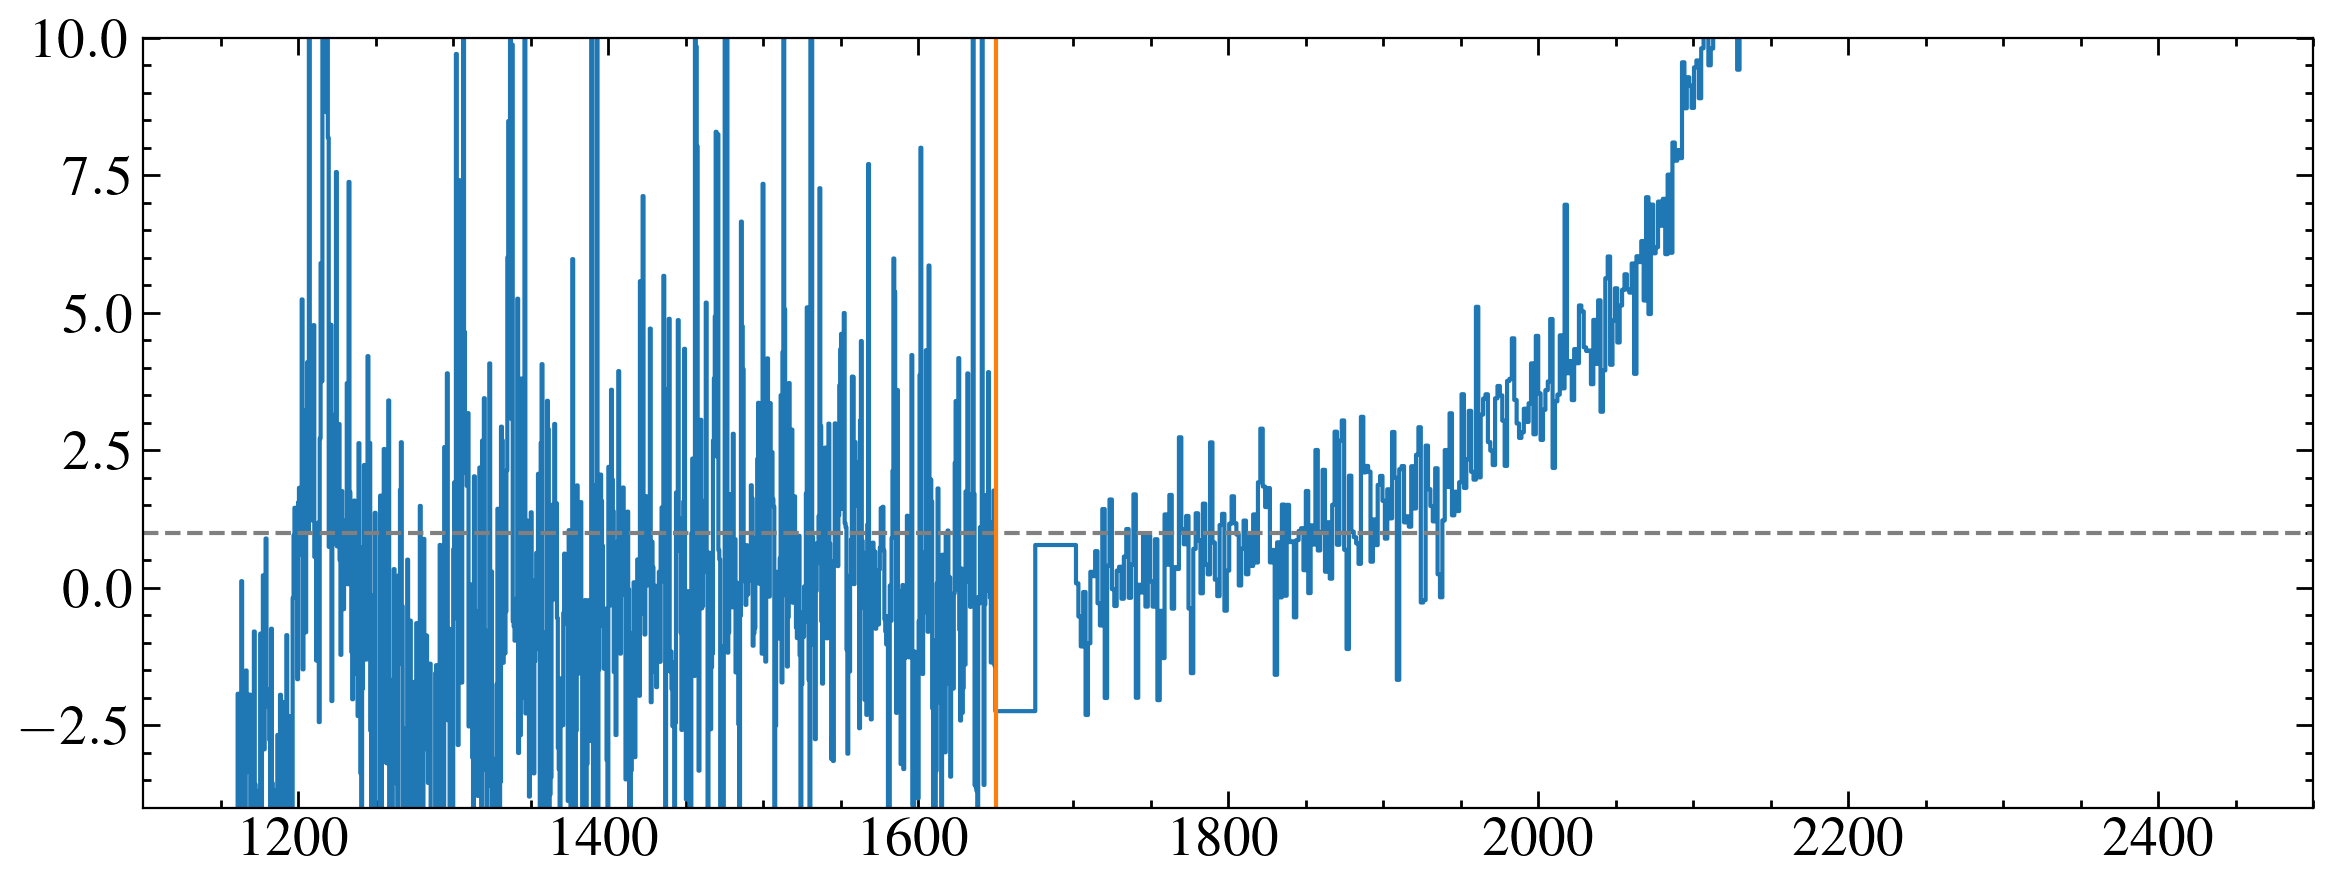

In [103]:
plt.step(w_stis, f_stis/e_stis, where='mid')
plt.axhline(1, ls='--', c='0.5')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(1100, 2500)
plt.ylim(-4, 10)
plt.axvline(goodbands['G140L'][1], c='C1')

In [26]:
# #open fancy solar spectrum
# import netCDF4 as nc
# tsis = nc.Dataset('../hybrid_reference_spectrum_c2021-03-04_with_unc.nc')
# wssi, fssi = np.array(tsis.variables['Vacuum Wavelength']), np.array(tsis.variables['SSI'])

# # plt.plot(tsis.variables['Vacuum Wavelength'], tsis.variables['SSI'])
# plt.plot(wssi*10, fssi)
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(w_sol, f_sol)

In [104]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

def remove_negatives(w, f, e):
    """
    Iteratvly removes negative values by combining them with adjecent bins
    """
    wn, fn, en = w, f, e  
    nz = len(fn[fn <0.0]) 
#     print(nz)
    minfi = np.argmin(fn) # most negative point
    fi = fn[minfi]
    while fi < 0:
        if len(fn) > 2: #can't handle an array less than 2 long
            w0, w1 = wavelength_edges(wn)
            delinds = [] #indices to delete when we're done
            start, end = minfi-1, minfi+2
            if minfi == 0: 
                start = minfi
            elif minfi == len(fn)-1:
                end = minfi +1
            delinds.append(start)
            delinds.append(end-1)
            fi = np.sum(fn[start:end]*(w1[start:end]-w0[start:end])) / (w1[end-1] - w0[start])
            ei = (np.sum(en[start:end]**2 * (w1[start:end]-w0[start:end])**2))**0.5                
            wi = (w0[start]+w1[end-1])/2
            wn[minfi], fn[minfi], en[minfi] = wi, fi, ei
            delinds = np.array(delinds)
            delinds = np.unique(delinds[(delinds != minfi) & (delinds >= 0) & (delinds < len(fn)-1)])
            wn, fn, en  = np.delete(wn, delinds), np.delete(fn, delinds), np.delete(en, delinds)
            minfi = np.argmin(fn) # most negative point
            fi = fn[minfi]
            nz = len(fn[fn <0.0])
#             print('len', len(fn))
#             print(nz)
        else:
            fi = 1e9
    return(wn[fn >0], fn[fn >0], en[fn >0])

In [28]:
print(np.trapz(f_stis, w_stis))
wneg, fneg, eneg = remove_negatives(w_stis, f_stis, e_stis)
print(np.trapz(fneg, wneg))


6.910959410026948e-10
6.911297792862491e-10


In [29]:
# plt.step(wneg, fneg, alpha =0.5)

# plt.plot(w_sol, f_sol*nuv_ratio, zorder=-1)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(10, 6000)
# plt.ylim(1e-19)

Check sol spectrum for errorbars. Not helpful

In [30]:
# from scipy.io.idl import readsav

# idlspec = readsav('Solar-data.idlsav')
# idlspec

Error on sol spectrum- MC? Generate a bunch of FUV spectra, scale sol?

In [31]:
# starmask = (w_stis > 1160) & (w_stis < 1210) | (w_stis > 1220) & (w_stis < 1650)#cut out lya 
# sunmask = (w_sol > 1160) & (w_sol < 1210) | (w_sol > 1220) & (w_sol < 1650)#cut out lya
# fuvstar = np.trapz(f_stis[starmask], w_stis[starmask])
# fuvsol = np.trapz(f_sol[sunmask], w_sol[sunmask])
# print(fuvstar, fuvsol)
# fuv_ratio = fuvstar/fuvsol
# print(fuv_ratio)

# w_fuv, f_fuv, e_fuv = w_stis[starmask], f_stis[starmask], e_stis[starmask]

# nspec = 10000
# fuvscales = []
# n = 0 

# while n < nspec:
#     f_rand =  np.random.normal(f_fuv, e_fuv)
#     plt.plot(w_fuv, f_rand, alpha =0.1, c='C0')
#     f_int = np.trapz(f_rand, w_fuv)
#     fuvscales.append(f_int)
#     n += 1
    
# plt.show()

# plt.hist(fuvscales)
# mean_scale = np.mean(fuvscales)
# std_scale = np.std(fuvscales)
# print(mean_scale, np.median(fuvscales), std_scale)

# plt.show()

# mean_ratio = mean_scale/fuvsol
# print(mean_ratio)
# ratio_up = (mean_scale+std_scale) / fuvsol
# ratio_down = (mean_scale-std_scale) / fuvsol


# plt.step(w_stis, f_stis, alpha=0.5, where='mid', c='C0')
# plt.step(w_sol, f_sol*mean_ratio, zorder=-1,where='mid', c='C1')
# plt.step(w_sol, f_sol*ratio_up, zorder=-1,where='mid', c='C1', alpha=0.3)
# plt.step(w_sol, f_sol*ratio_down, zorder=-1,where='mid', c='C1', alpha=0.3)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(100, 6000)
# plt.ylim(1e-19)

# plt.show()

# e_sol = np.mean([(f_sol*ratio_up) - (f_sol*mean_ratio), (f_sol*mean_ratio) - (f_sol*ratio_down)], axis = 0)

# f_sol_scale = (f_sol*mean_ratio).value

# plt.plot(w_sol, f_sol_scale)
# plt.plot(w_sol, e_sol)
# plt.yscale('log')
# plt.xscale('log')

# print(np.median(f_sol_scale/e_sol))

# # plt.show()
# # sn = f_sol_scale/e_sol
# plt.plot(w_sol.value, sn)
# # plt.yscale('log')
# plt.xscale('log')
# plt.ylim(8.5, 10)

In [32]:
# savdat = Table([w_sol*u.AA, f_sol_scale*u.erg/u.s/u.cm**2/u.AA, e_sol*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'FLUX', 'ERROR'])
# ascii.write(savdat, 'scaled_solar/toi_421_solar_scaled.ecsv', format='ecsv', overwrite = True)

In [33]:
# plt.step(w_fuv, f_fuv)
# plt.step(w_fuv, e_fuv)
# plt.xlim(1400, 1420)

PHOENIX model, parameters from Allison 

In [34]:

import prepare_phoenix_svo as pp
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.852
teff = 5325
teff_e = np.mean([78, -58])

radius = 0.871
distance = 74.96
save_path = 'models/'
star = 'TOI-421'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.486
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/TOI-421_phoenix_interpolated.ecsv')
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [35]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

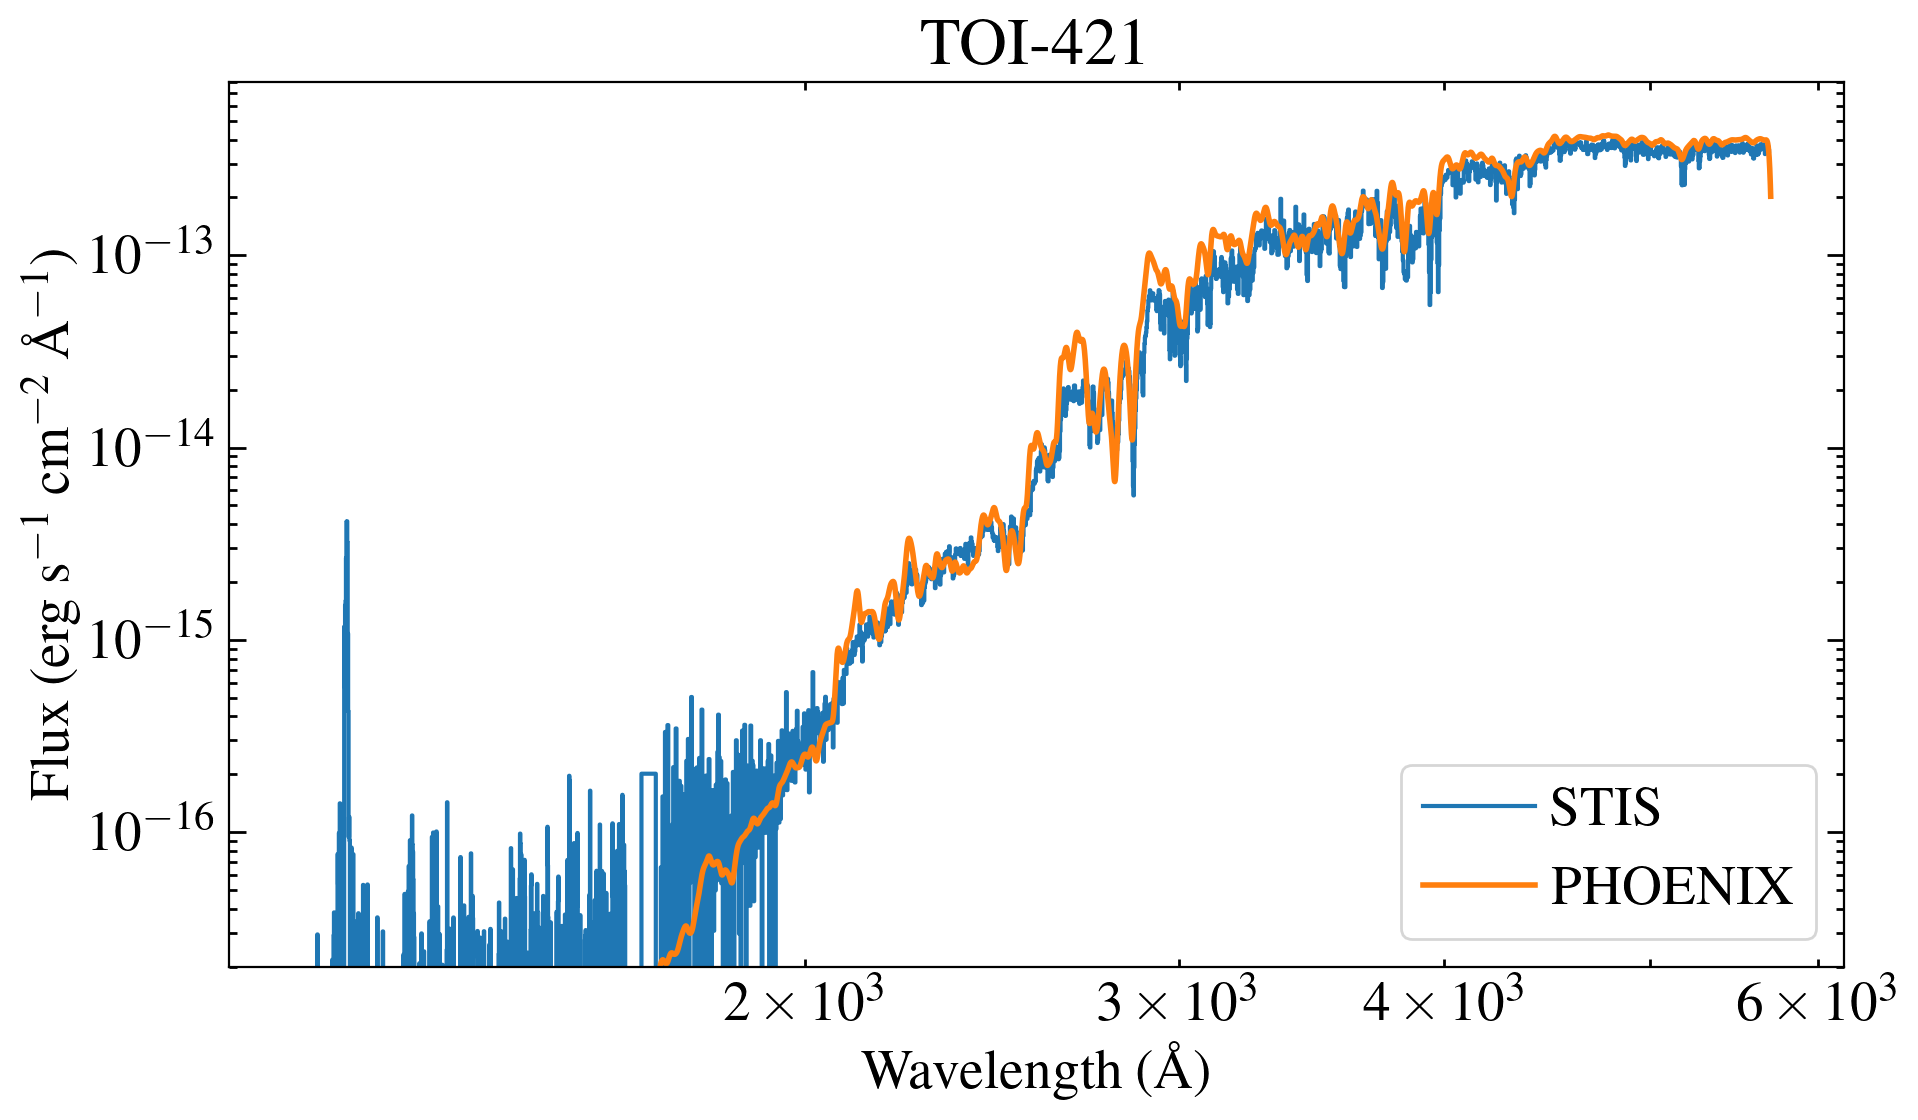

In [105]:
pmask = (pw > 1700) & (pw < 5700)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 500)
plt.figure(figsize=(10, 6))
plt.step(w_stis, f_stis, label='STIS', where='mid')
# plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=4)

plt.title('TOI-421')
# plt.xlim(1980, 5650)
plt.ylim(2e-17, 8e-13)
plt.tight_layout()

6.685788077161616e-10 7.523528398220877e-10 0.8886506069070776


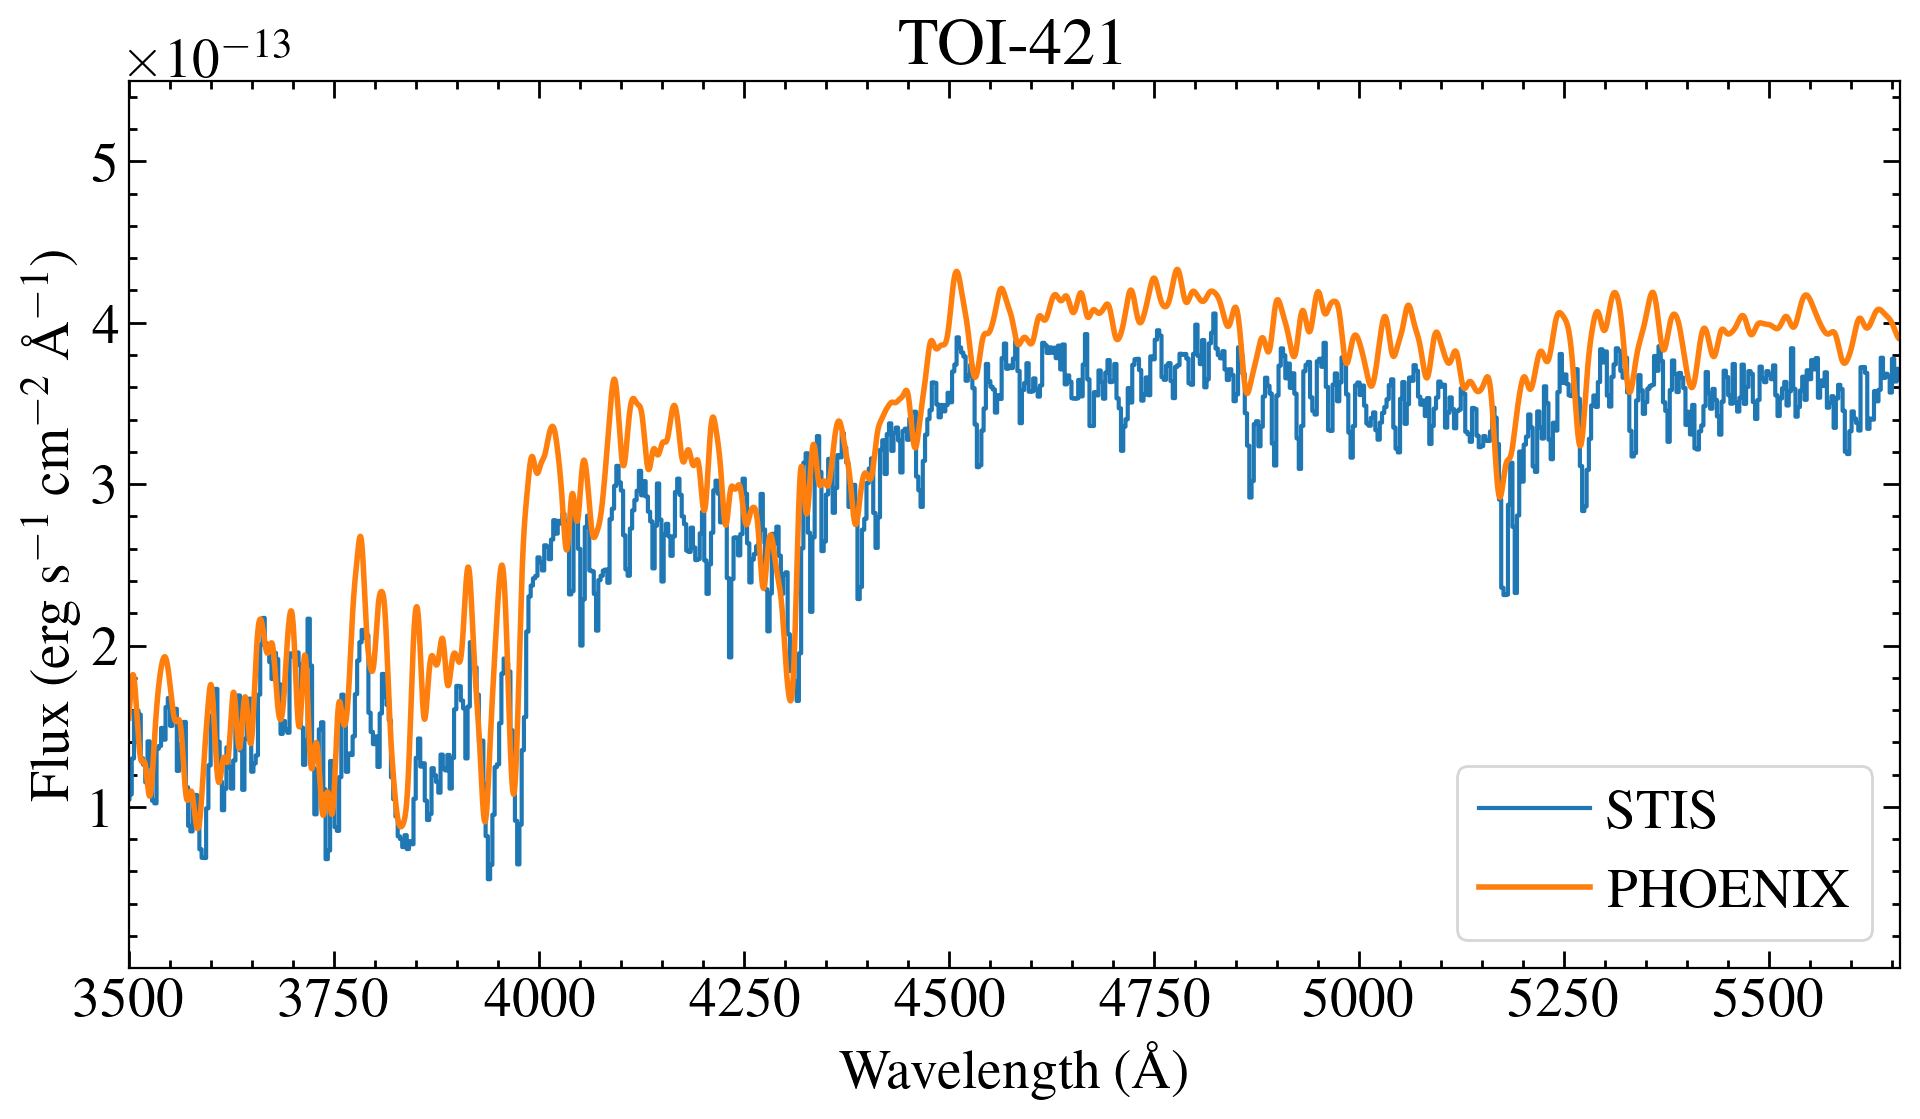

In [106]:
pmask = (pw > 1700) & (pw < 5700)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 1000)
plt.figure(figsize=(10, 6))
plt.step(w_stis, f_stis, label='STIS', where='mid')
# plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=4)

plt.title('TOI-421')
plt.xlim(3500, 5660)
plt.ylim(2e-17, 5.5e-13)
plt.tight_layout()

omask = (w_stis > goodbands['G430L'][0]) & (w_stis < goodbands['G430L'][-1])
pomask = (pwi > goodbands['G430L'][0]) & (pwi < goodbands['G430L'][-1])

oint = np.trapz(f_stis[omask], w_stis[omask])
pint = np.trapz(pfi[pomask], pwi[pomask])

print(oint, pint, oint/pint)

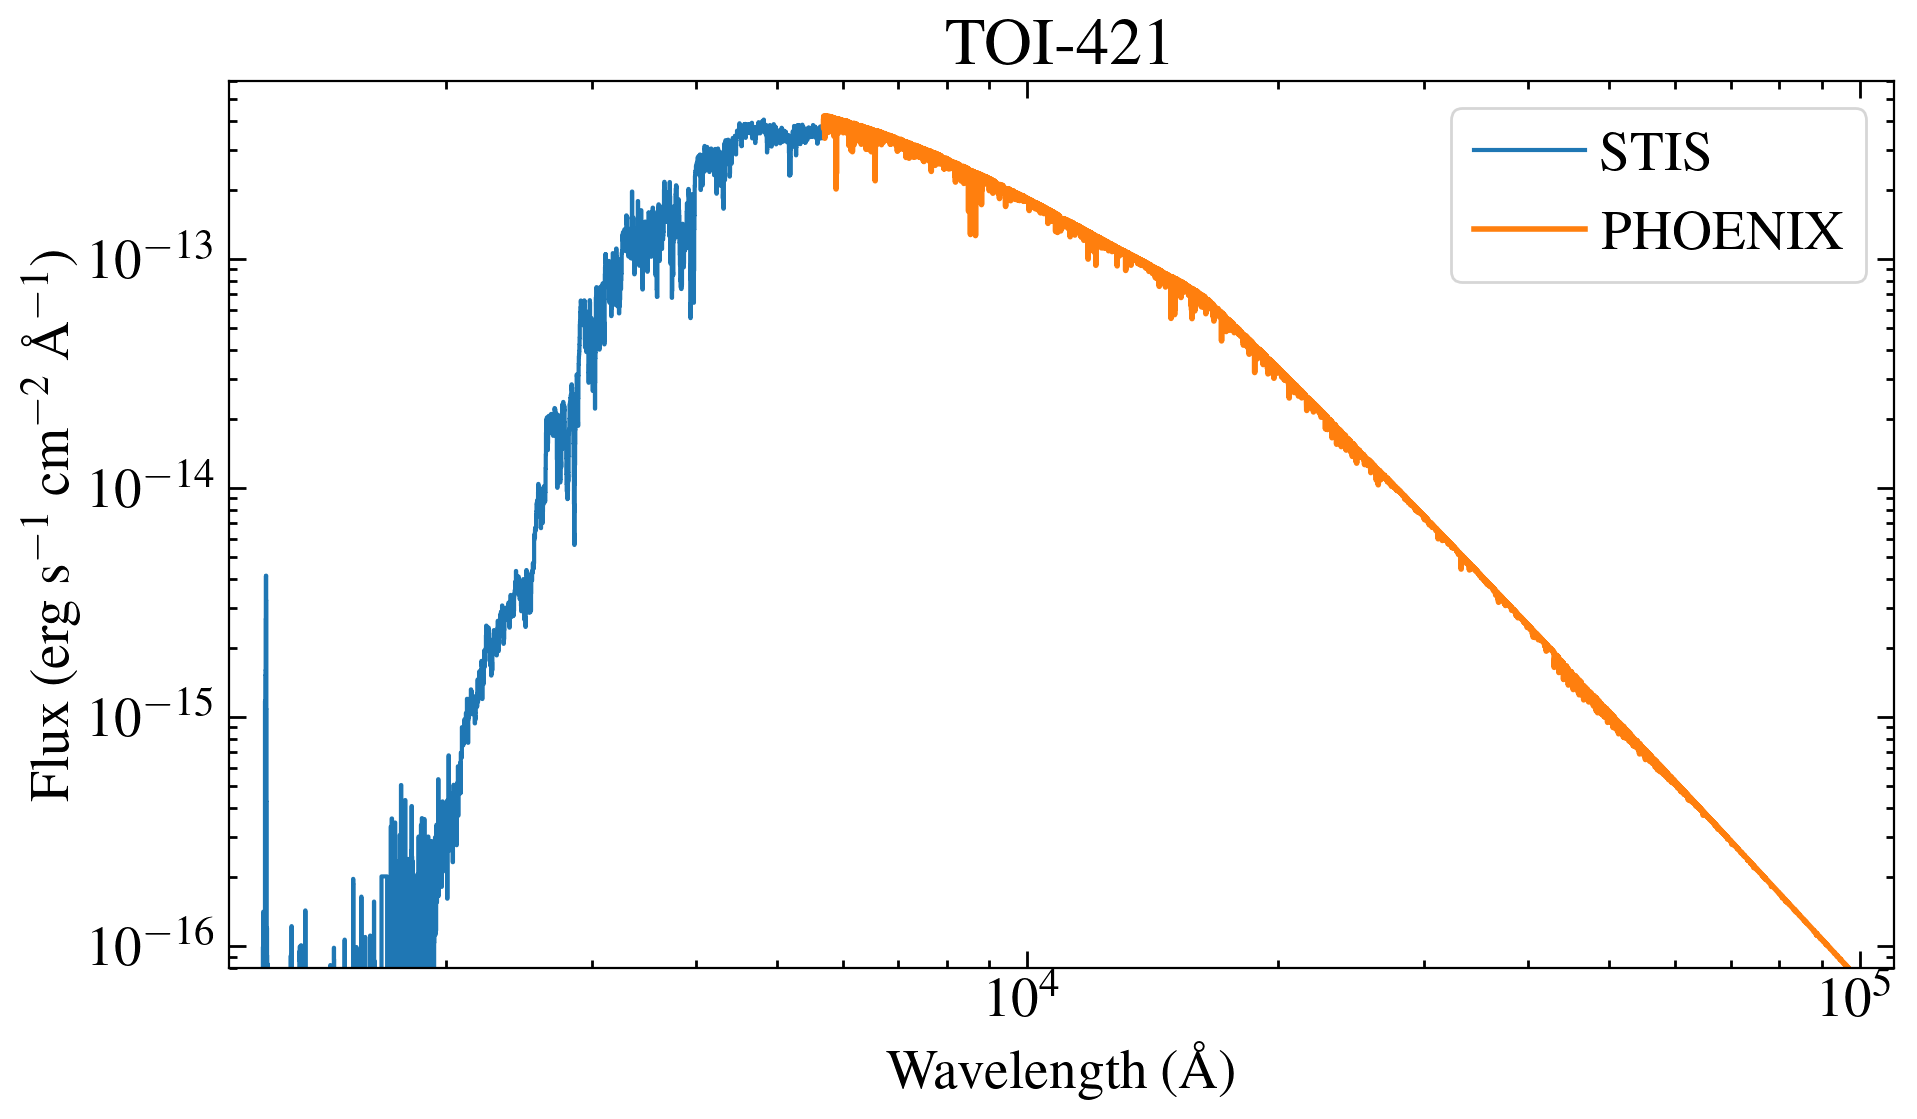

In [107]:

pmask = (pw > 5000) 
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 10000)
plt.figure(figsize=(10, 6))
plt.step(w_stis, f_stis, label='STIS', where='mid')
# plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi[pwi > goodbands['G430L'][-1]], pfi[pwi > goodbands['G430L'][-1]], lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=1)

plt.title('TOI-421')
plt.xlim(1100, 1.1e5)
plt.ylim(8e-17, 6e-13)

plt.tight_layout()
plt.savefig('plots/toi_421_stis_phx.png', facecolor='w')
plt.savefig('plots/toi_421_stis_phx.pdf', facecolor='w')

In [39]:
normfac

<Quantity 6.86309595e-20>

In [40]:
if 'ERROR' in pdata.dtype.names:
    print ('yes')

yes


In [41]:
import prepare_model
importlib.reload(prepare_model)

# hdr = fits.getheader('draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g140l_v1_component-spec.fits',0)
sed_data = Table.read('draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g140l_v1_component-spec.ecsv')


# prepare_model.make_model_spectrum('models/TOI-421_phoenix_interpolated.ecsv', 1, sed_data ,savepath = 'draft_hlsp/toi-421/', save_ecsv=True, save_fits=True, normfac=normfac, model_name='PHX')

Can I use swift data to scale the G430L spectrum or models (or see which is better?). First need to see if there's a Uband obs

In [42]:
# swiftpath = '/media/david/2tb_ext_hd/hddata/meats/swift/toi421/uvot'

# skims = glob.glob('{}/*/uvot/products/*sk.img*'.format(swiftpath))

# for skim in skims:
#     print(skim)
#     band = fits.getheader(skim, 1)['FILTER']
#     print(band)

Sadness :(

In [43]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 

3.284373300726555e-13 3.0530657368100006e-13 erg / (Angstrom cm2 s)
3.553575172887701e-13 3.4442935420743647e-13 erg / (Angstrom cm2 s)
2.80786149381702e-13 2.6169129752918946e-13 erg / (Angstrom cm2 s)
[0.94657111]


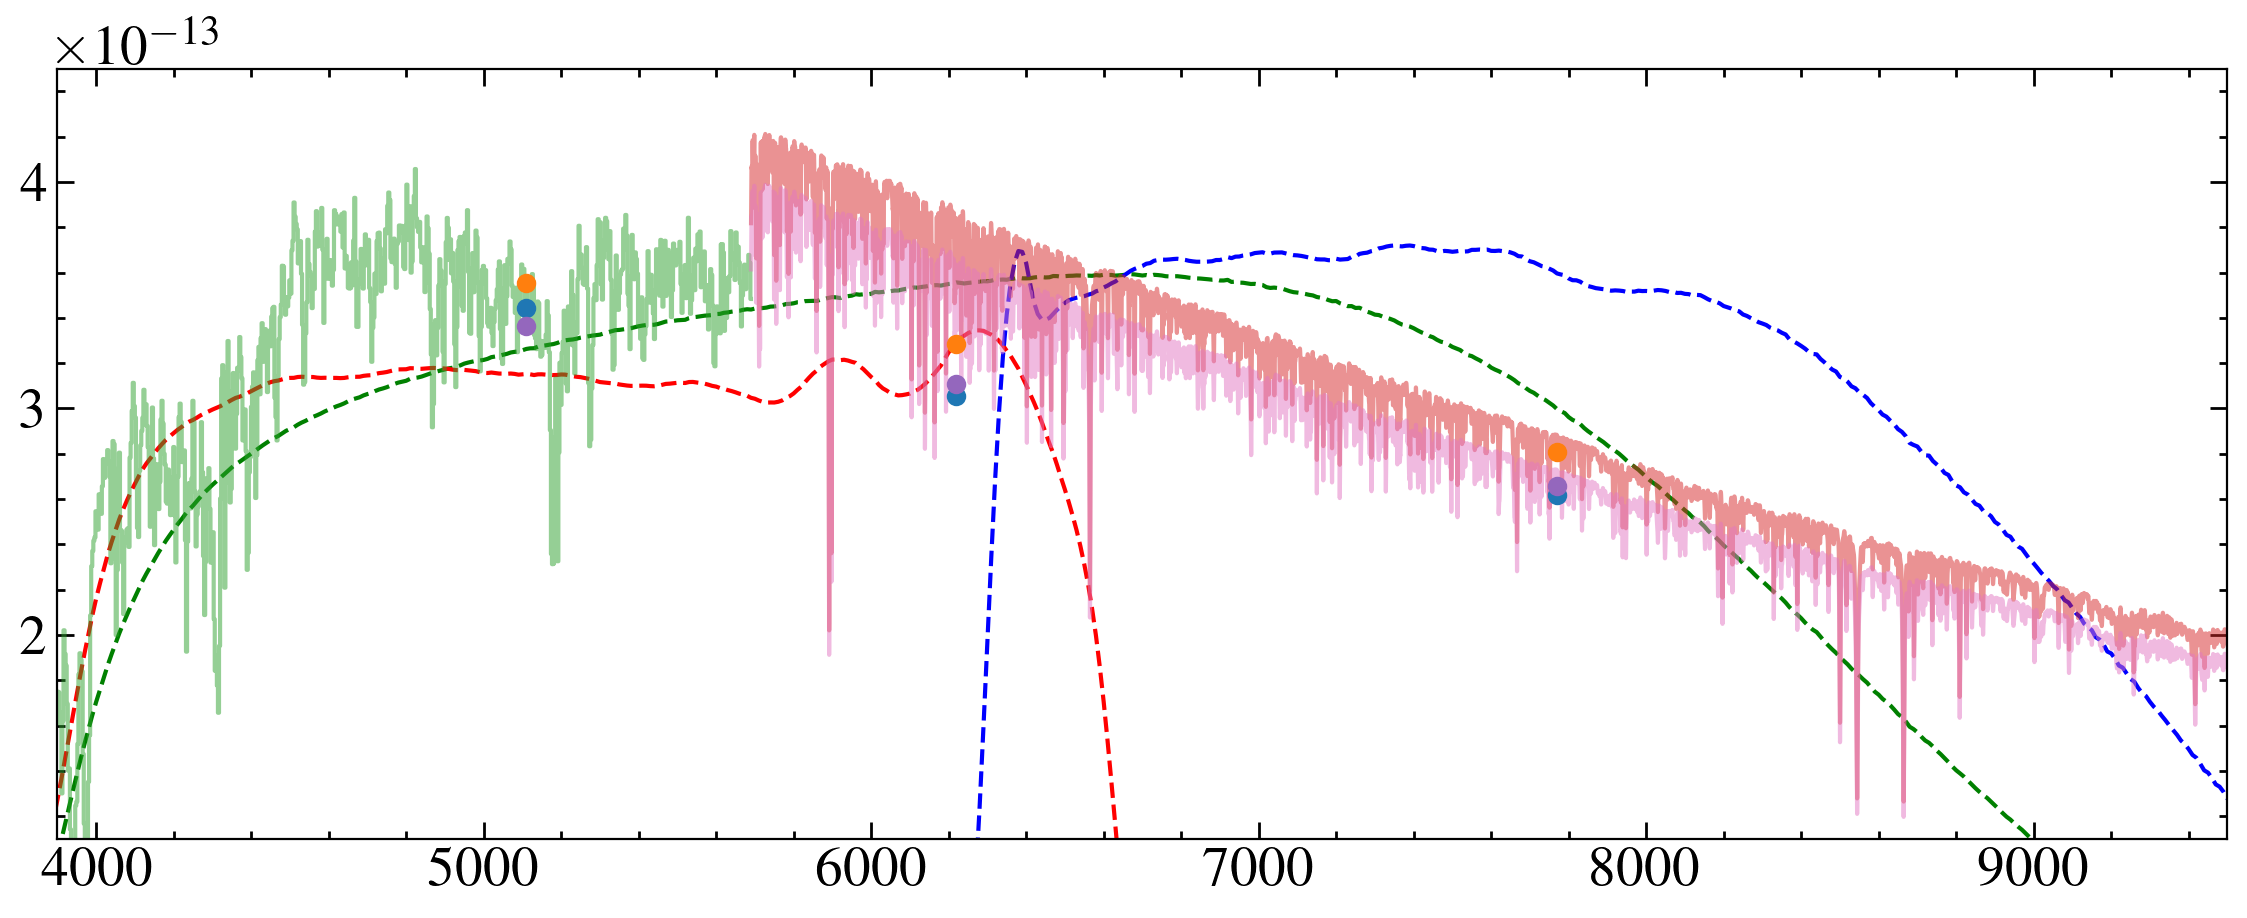

In [44]:
#gaia mags
gaiaGp = 9.783354
gaiaBp = 10.184568
gaiaRp = 9.213981

rflux = 0.527*u.Jy 
bflux = 0.300*u.Jy
gflux = 0.394*u.Jy
re = 0.002*u.Jy
be = 0.001*u.Jy
ge = 0.001*u.Jy

gaiamags = [gaiaGp, gaiaBp, gaiaRp]

gaiaflux = [gflux, bflux, rflux]
gaiaerr = [ge, be, re]

gaiaw = np.array([0.622, 0.511,0.777])*u.um

# gaiabands = glob.glob('/home/david/work/filters/gaia/EDR3/*p.dat')
gaiabands = ['/home/david/work/filters/gaia/EDR3/Gp.dat',
 '/home/david/work/filters/gaia/EDR3/Bp.dat',
 '/home/david/work/filters/gaia/EDR3/Rp.dat']

gaiacols = ['g', 'r', 'b']

# guessscale = 0.93

gaiaergs = []
pergs =[]

for i, band in enumerate(gaiabands):
    bp_w, bp_cc = np.loadtxt(band, unpack=True)
    plt.plot(bp_w, bp_cc*5e-13, c=gaiacols[i], ls='--')
    pmag = make_phot(bp_w, bp_cc, pw, pf*normfac.value)
    gerg = gaiaflux[i].to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(gaiaw[i]))
    gerge = (gaiaerr[i].value) * gerg.value
    gaiaergs.append(gerg.value)
    pergs.append(pmag)
    
    print(pmag, gerg)
    
    plt.errorbar(gaiaw[i].to(u.AA), gerg.value, yerr= gerge, marker='o', ls='none', c='C0')
    plt.errorbar(gaiaw[i].to(u.AA), pmag, marker='o', ls='none', c='C1')
    # plt.errorbar(gaiaw[i].to(u.AA), pmag*guessscale, marker='o', ls='none', c='C4')
  

def residuals(scale, f, mf):
    return f - mf/scale

guessscale = leastsq(residuals, 1., args=(pergs, gaiaergs))[0]
print(guessscale)

plt.errorbar(gaiaw.to(u.AA), pergs*guessscale, marker='o', ls='none', c='C4')

    
plt.step(w_stis, f_stis, label='STIS', where='mid', alpha=0.5, c='C2')
# plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow, of, where='mid', label='G430L', zorder=-1)
plt.xlim(3900, 9500)
plt.ylim(1.1e-13, 4.5e-13)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi[pwi > goodbands['G430L'][-1]], pfi[pwi > goodbands['G430L'][-1]], label= 'PHOENIX', alpha=0.5, c='C3')
plt.plot(pwi[pwi > goodbands['G430L'][-1]], pfi[pwi > goodbands['G430L'][-1]]*guessscale, label= 'PHOENIX', alpha=0.5, c='C6')
    

6.685788077161616e-10 7.12170517817437e-10 0.938790347240336


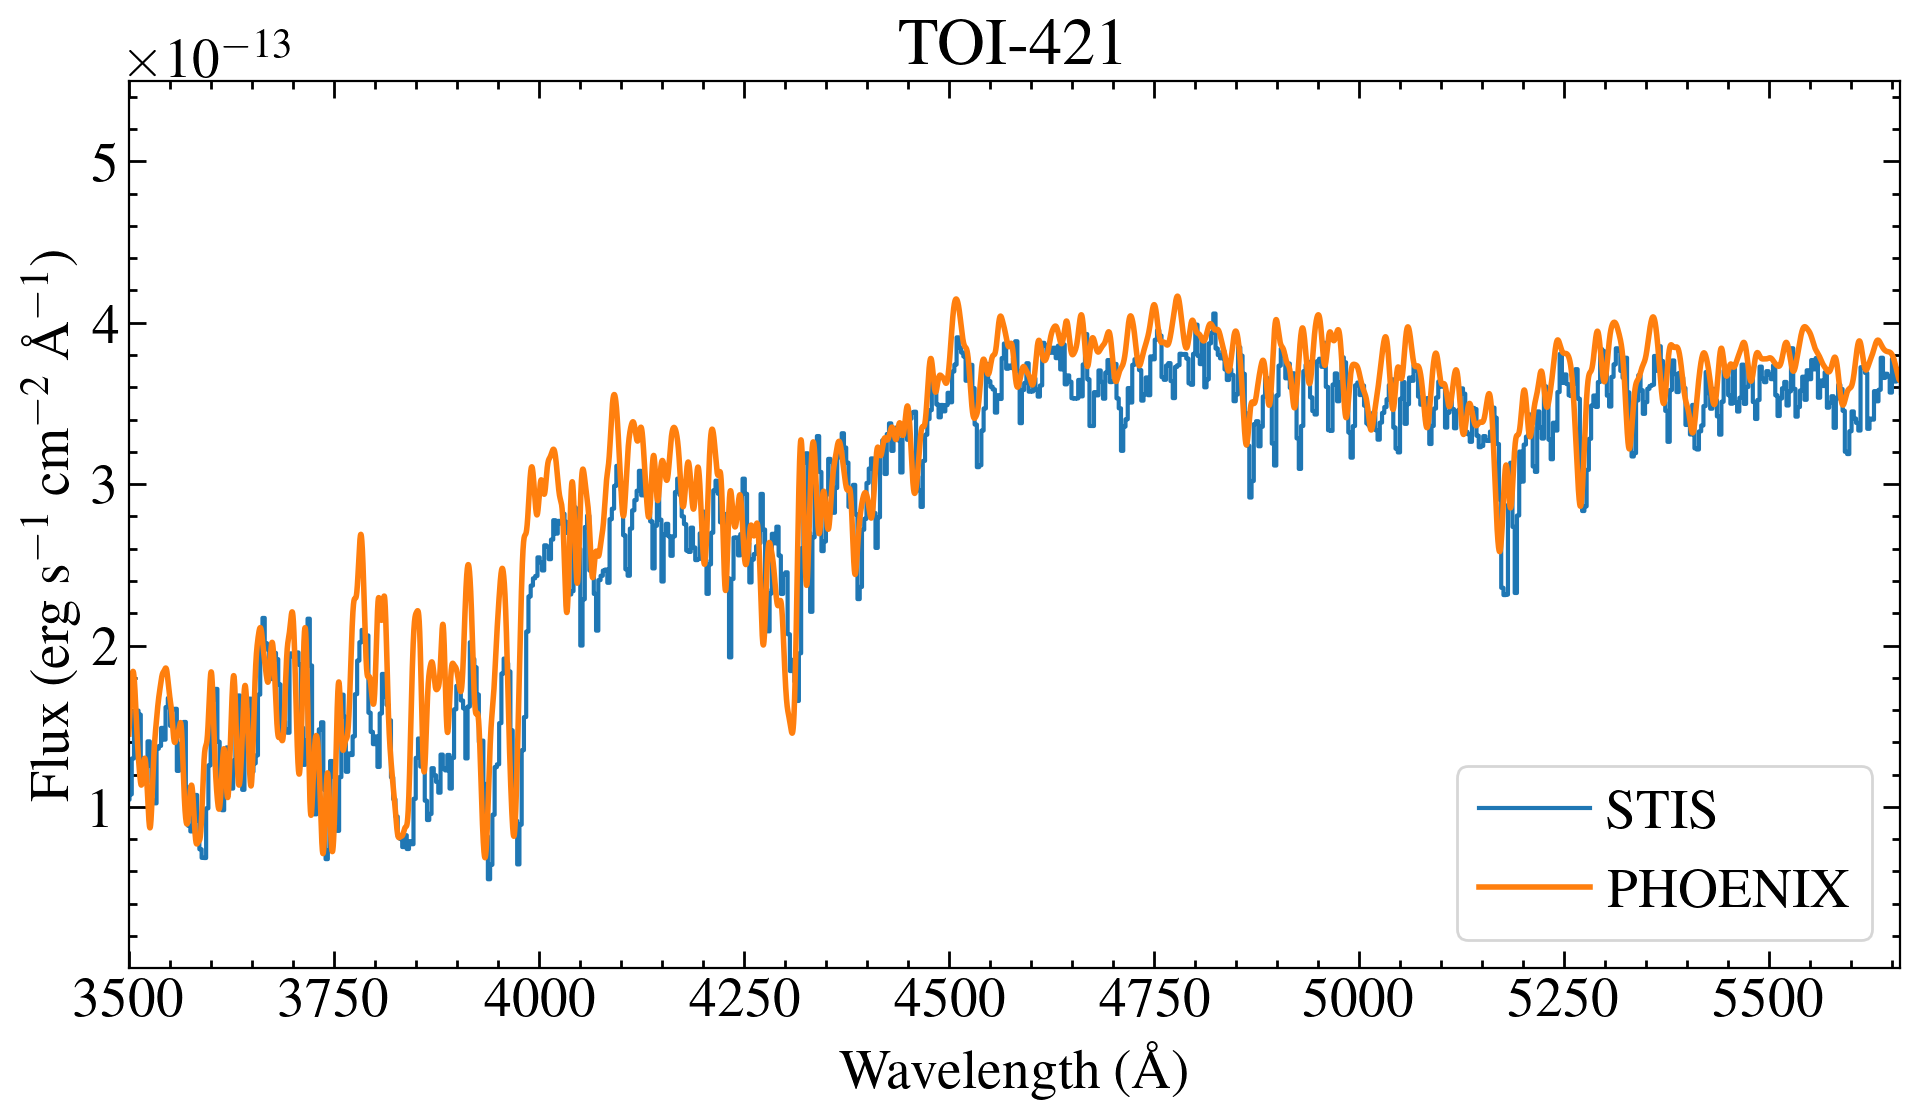

In [45]:
pmask = (pw > 1700) & (pw < 5700)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 1500)
plt.figure(figsize=(10, 6))
plt.step(w_stis, f_stis, label='STIS', where='mid')
# plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi*guessscale, lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=4)

plt.title('TOI-421')
plt.xlim(3500, 5660)
plt.ylim(2e-17, 5.5e-13)
plt.tight_layout()

omask = (w_stis > goodbands['G430L'][0]) & (w_stis < goodbands['G430L'][-1])
pomask = (pwi > goodbands['G430L'][0]) & (pwi < goodbands['G430L'][-1])

oint = np.trapz(f_stis[omask], w_stis[omask])
pint = np.trapz(pfi[pomask]*guessscale, pwi[pomask])

print(oint, pint, oint/pint)

In [51]:
demlines = Table.read('DEM_goodlinelist .csv')
demlines.dtype.names

('Ion', 'Wavelength', 'Likelihood to measure', 'Log Formation Temperature')

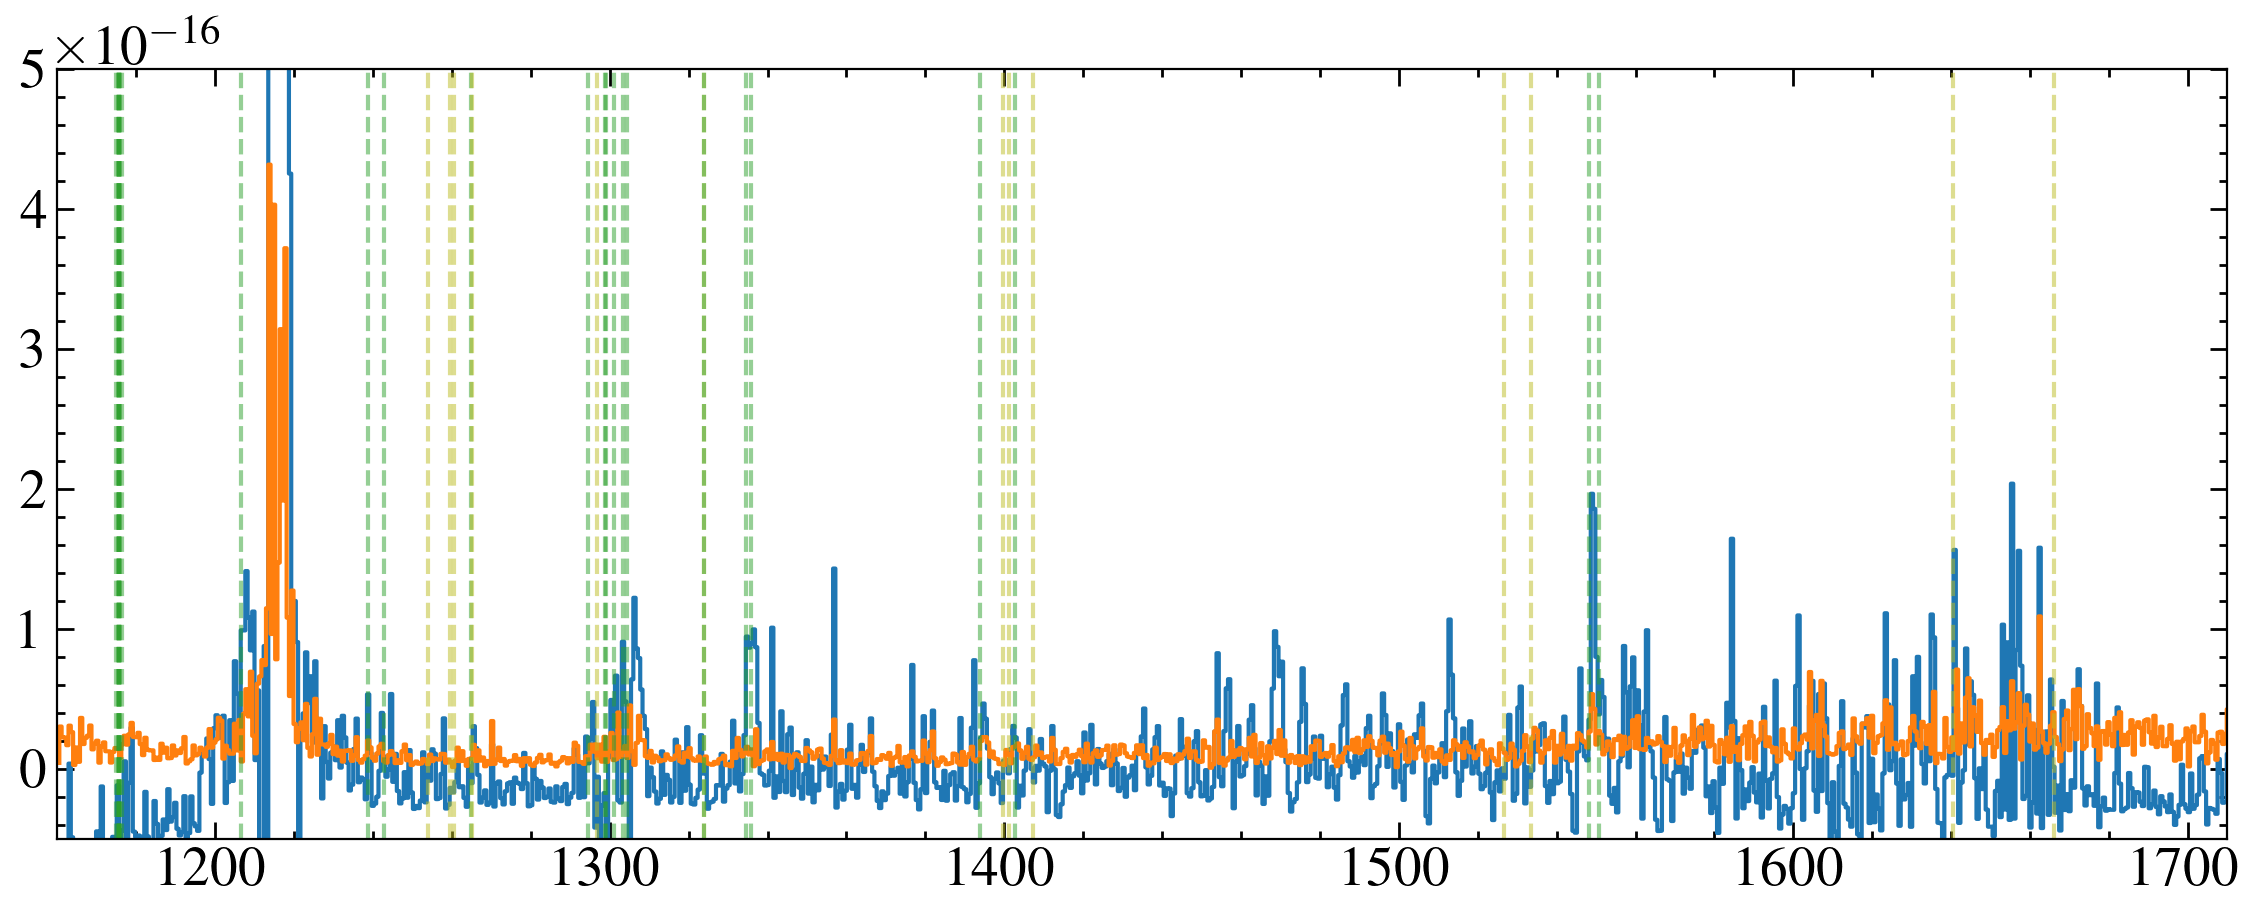

In [96]:
hlsp_x1ds = glob.glob('draft_hlsp/toi-421/*stis*.fits')

for x in hlsp_x1ds[3:]:
    data = fits.getdata(x, 1)
    grating = fits.getheader(x, 0)['GRATING']
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'G140L':
        w, f, e, = w[w > 1160], f[w > 1160], e[w > 1160] 
    plt.step(w, f)
    plt.step(w, e)
    
    for i, line in enumerate(demlines['Wavelength']):
        c= 'C2'
        if demlines['Likelihood to measure'][i] == 'Medium':
            c = 'C8'
        if demlines['Likelihood to measure'][i] == 'Low':
            c = 'C3'
        if demlines['Likelihood to measure'][i] != 'Low':
            plt.axvline(line, c = c, ls='--', alpha=0.5)
    plt.xlim(1160, 1710)
    plt.ylim(-0.5e-16, 5e-16)
    
#     plt.yscale('log')
    plt.show()

This spectrum is really bad, can I make it better?